# This notebook makes variables for the credit card transaction data. 

The notebook cleans the raw credit card transaction data and creates a set of engineered features for fraud detection modeling. It handles missing merchant and state information, filters the data to relevant transactions, and builds time-based, customer-level, and merchant-level features. Target encoding is applied to key categorical variables, and rolling statistics are computed to capture behavioral patterns over different time windows. The final output is a clean, enriched dataset ready for feature selection and modeling.

In [1]:
import pandas as pd
import numpy as np
import datetime
import calendar
import timeit
import datetime as dt
import re
from math import exp
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import warnings
start_time = dt.datetime.now()

In [2]:
data = pd.read_csv('card transactions.csv')
data.shape

(97852, 10)

In [3]:
data.dropna(how='all', axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97852 entries, 0 to 97851
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97852 non-null  int64         
 1   Cardnum            97852 non-null  int64         
 2   Date               97852 non-null  datetime64[ns]
 3   Merchnum           94455 non-null  object        
 4   Merch description  97852 non-null  object        
 5   Merch state        96649 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97852 non-null  object        
 8   Amount             97852 non-null  float64       
 9   Fraud              97852 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.5+ MB


In [4]:
data = data[data['Transtype'] == 'P']
data = data[data['Amount'] <= 3000000]
data.shape

(97496, 10)

In [5]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3220
Merch description       0
Merch state          1028
Merch zip            4347
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [6]:
data_orig = data.copy()

## Clean and impute merchnum

In [7]:
data['Merchnum'] = data['Merchnum'].replace({'0':np.nan})

In [8]:
data['Merchnum'].isnull().sum()

3279

In [12]:
merchdes_merchnum = {}
# modified the line below by adding &
for index, merchdes in data[data['Merch description'].notnull() & data['Merchnum'].notnull()]['Merch description'].items():
    if pd.isnull(merchdes) == True:
        continue
    elif merchdes not in merchdes_merchnum:
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

In [15]:
# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

In [16]:
data['Merchnum'].isnull().sum()

2115

In [17]:
# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [18]:
data['Merchnum'].isnull().sum()

1421

In [19]:
data.loc[data.Merchnum.isna(), 'Merch description'].unique()[:20]

array(['MONTGOMERY COLLEGE-PHONE', 'COMPRESSOR PARTS & SERVIC',
       'WESTERN SUN             0', 'PACKAGE PLACE  THE',
       'CUBIX CORPORATION', 'SIGNAL GRAPHICS PRINTING',
       'C & M OFFICE EQUIPMENT', "TOMMY'S TRAILERS",
       'Z WORLD/RABBIT SEMICONDUC', 'IMPAC/TRI-COUNTY/FREED',
       'REPROGRPHC TECHNLGIES INC', 'STP SPECIALITY TECH',
       'VANGARD INTERNAITONAL', 'COSTCO WHOLESALE        0',
       'BLACKWELL SCIENCE', 'CDN ISOTOPES INC', 'INTERACTIVE SOFTWARE S',
       'H R WILLIAMS MILL SUPP', 'ELSEVIER SCIENCE BV',
       'COLORADO GARDEN SHOW'], dtype=object)

In [21]:
# 1403 NULL Merchnums with 508 unique Descriptions
data.loc[data.Merchnum.isna(), 'Merch description'].nunique()

515

### Create new Merchnums using the description field

In [22]:
# adding new merchnums
# each new unique merchnum will be max(merchnum) + 1
merchnum_create = {}
max_merchnum = pd.to_numeric(data.Merchnum, errors='coerce').max()
for merch_desc in data.loc[data.Merchnum.isna(), 'Merch description'].unique():
  merchnum_create[merch_desc] = str(int(max_merchnum + 1))
  max_merchnum += 1

In [23]:
# fill in by mapping with Merch description (newly created merchnums)
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchnum_create))

In [24]:
for i in data.columns:
    print(i, data[i].isnull().sum())

Recnum 0
Cardnum 0
Date 0
Merchnum 0
Merch description 0
Merch state 1028
Merch zip 4347
Transtype 0
Amount 0
Fraud 0


## Clean and impute State

In [25]:
data['Merch state'].isnull().sum()

1028

In [26]:
data[data['Merch state'].isnull()].head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
283,284,5142257575,2010-01-04,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,320.00,0
293,294,5142124791,2010-01-04,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,970.00,0
440,441,5142276099,2010-01-04,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,82.59,0
530,531,5142267793,2010-01-05,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,17.59,0
542,543,5142267793,2010-01-05,unknown,RETAIL CREDIT ADJUSTMENT,NaN,NaN,P,19.69,0


In [27]:
data[(data['Merch state'].isnull()) & (data['Merch zip'].notnull())]['Merch zip'].unique()

array([9.2600e+02, 9.2900e+02, 1.4000e+03, 6.5132e+04, 8.6899e+04,
       2.3080e+04, 6.0528e+04, 9.3400e+02, 9.0200e+02, 7.3800e+02,
       9.0805e+04, 7.6302e+04, 9.0000e+00, 9.1400e+02, 6.0000e+00,
       9.5461e+04, 5.0823e+04, 2.0000e+00, 4.8700e+04, 6.8000e+02,
       1.0000e+00, 6.8100e+02, 6.2300e+02, 7.2600e+02, 9.3600e+02,
       1.2108e+04, 7.9100e+02, 9.0700e+02, 9.2200e+02, 9.2000e+02,
       3.0000e+00, 8.0100e+02, 8.0000e+00, 3.1040e+04, 3.8117e+04,
       4.1160e+04])

In [28]:
# dict for mapping
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']

In [29]:
zip_state[926.0] = 'PR'
zip_state[929.0] = 'PR'
zip_state[934.0] = 'PR'
zip_state[902.0] = 'PR'
zip_state[738.0] = 'PR'
zip_state[90805.0] = 'CA'
zip_state[76302.0] = 'TX'
zip_state[914.0] = 'PR'
zip_state[95461.0] = 'CA'
zip_state[680.0] = 'PR'
zip_state[623.0] = 'PR'
zip_state[726.0] = 'PR'
zip_state[936.0] = 'PR'
zip_state[12108.0] = 'NY'
zip_state[791.0] = 'PR'
zip_state[907.0] = 'PR'
zip_state[922.0] = 'PR'
zip_state[920.0] = 'PR'
zip_state[801.0] = 'VI'
zip_state[31040.0] = 'GA'
zip_state[41160.0] = 'KY'
zip_state[681.0] = 'PR'

In [30]:
len(zip_state)

4567

In [31]:
merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

In [32]:
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [33]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'].isnull().sum()

1028

In [34]:
data[data['Merch state'].isnull() & data['Merch zip'].notnull()].head(100)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
3379,3380,5142153880,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2340.00,0
3383,3384,5142154098,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2387.00,0
3661,3662,5142154098,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2300.00,0
3763,3764,5142153880,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2500.00,0
5090,5091,5142194136,2010-01-24,597597721468,CRISTALIA ACQUISITION COR,NaN,929.0,P,83.00,0
...,...,...,...,...,...,...,...,...,...,...
84236,84237,5142193384,2010-10-26,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,300.00,0
84389,84390,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
84418,84419,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
87369,87370,5142194136,2010-11-10,7007631331,AAFES BUCHANAN MAIN STR,NaN,934.0,P,184.41,0


In [35]:
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'].isnull().sum()

954

### Nice! We reduced from 1020 to 947

In [36]:
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'].isnull().sum()

953

meh...

In [37]:
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))
data['Merch state'].isnull().sum()

952

double meh... 

In [38]:
# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [39]:
data['Merch state'].isnull().sum()

297

In [40]:
# change non-US states
# might actually be useful cus fraud could be foreign transactions
# maybe put a 'foreign' tag or just leave them as is

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", 
          'VI', 'PR', np.nan, 'unknown']

for index, state in data['Merch state'].items():
    if state not in states:
        data.loc[index, 'Merch state'] = 'foreign'

In [41]:
data['Merch state'].fillna('unknown',inplace=True)

In [42]:
data['Merch state'].isnull().sum()

0

In [43]:
# Checking for wierd stuff, are we sure that all of those digits are gone?

Merch_group = data.groupby(['Merch state'])['Recnum'].count().to_frame().reset_index(drop=False)
pd.set_option('display.max_rows', 300)
Merch_group.head(100)

,Merch state,Recnum
0,AK,164
1,AL,348
2,AR,34
3,AZ,348
4,CA,6896
5,CO,2008
6,CT,964
7,DC,3235
8,DE,71
9,FL,2165


## Clean and impute zip

In [44]:
data['Merch zip'].isnull().sum()

4347

In [45]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

In [46]:
merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [47]:
# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

In [48]:
data['Merch zip'].isnull().sum()

2625

In [49]:
# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [50]:
data['Merch zip'].isnull().sum()

2625

In [51]:
temp = data[data['Merch zip'].isna()]
temp.head(10)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
53,54,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
57,58,5142146340,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,23.90,0
58,59,5142260984,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,19.95,0
61,62,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
62,63,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
63,64,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
64,65,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
65,66,5142253356,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,27.41,0
67,68,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
68,69,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0


## "Merch zip" impute strategy -
If State is known, but zip is not, will impute the most populated zip code in the state

In [53]:
# Create a dictionary with each state's two-letter ID and its corresponding most populous zip code. Got this info online.

mostPopZip = {'AL': 35205, 'AK': 99501, 'AZ': 85281, 'AR': 72701, 'CA': 90026, 'CO': 80219, \
              'CT': 6511, 'DE': 19801, 'FL': 33139, 'GA': 30303, 'HI': 96744, 'ID': 83702, \
              'IL': 60647, 'IN': 46201, 'IA': 52404, 'KS': 66102, 'KY': 40203, 'LA': 70119, \
              'ME': 4101, 'MD': 21224, 'MA': 2118, 'MI': 48201, 'MN': 55406, 'MS': 38801, \
              'MO': 63118, 'MT': 59101, 'NE': 68104, 'NV': 89101, 'NH': 3103, 'NJ': 7030, \
              'NM': 87102, 'NY': 11226, 'NC': 28202, 'ND': 58102, 'OH': 44113, 'OK': 74120, \
              'OR': 97214, 'PA': 19107, 'RI': 2903, 'SC': 29203, 'SD': 57103, 'TN': 37203, \
              'TX': 77002, 'UT': 84101, 'VT': 5401, 'VA': 22201, 'WA': 98122, 'WV': 25301, 'WI': 53204, 'WY': 82001}
print(mostPopZip)

{'AL': 35205, 'AK': 99501, 'AZ': 85281, 'AR': 72701, 'CA': 90026, 'CO': 80219, 'CT': 6511, 'DE': 19801, 'FL': 33139, 'GA': 30303, 'HI': 96744, 'ID': 83702, 'IL': 60647, 'IN': 46201, 'IA': 52404, 'KS': 66102, 'KY': 40203, 'LA': 70119, 'ME': 4101, 'MD': 21224, 'MA': 2118, 'MI': 48201, 'MN': 55406, 'MS': 38801, 'MO': 63118, 'MT': 59101, 'NE': 68104, 'NV': 89101, 'NH': 3103, 'NJ': 7030, 'NM': 87102, 'NY': 11226, 'NC': 28202, 'ND': 58102, 'OH': 44113, 'OK': 74120, 'OR': 97214, 'PA': 19107, 'RI': 2903, 'SC': 29203, 'SD': 57103, 'TN': 37203, 'TX': 77002, 'UT': 84101, 'VT': 5401, 'VA': 22201, 'WA': 98122, 'WV': 25301, 'WI': 53204, 'WY': 82001}


In [54]:
data['Merch zip'] = data['Merch zip'].fillna(data['Merch state'].map(mostPopZip))

In [55]:
data['Merch zip'].isnull().sum()

1216

In [56]:
data['Merch zip'].fillna('unknown', inplace=True)
data['Merch zip'].isnull().sum()

0

In [57]:
df = data.copy()

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97496 entries, 0 to 97851
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           97496 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        97496 non-null  object        
 6   Merch zip          97496 non-null  object        
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 10.2+ MB


## Strange spike in purchases of $3.62??

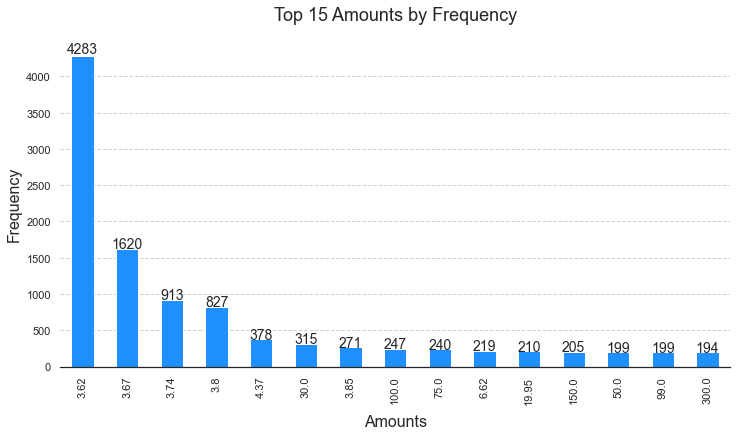

In [59]:
import matplotlib.dates as mdates
import seaborn as sns

# Set font size and figure size
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (12, 6)

# Use a custom color palette
sns.set(style="white", palette="viridis", rc={"figure.figsize": (12, 6), "lines.linewidth": 2})

# Create the bar plot
ax = data['Amount'].value_counts().head(15).plot(kind='bar', color='dodgerblue')

# Add a title and labels
plt.title('Top 15 Amounts by Frequency', fontsize=18, pad=20)
plt.xlabel('Amounts', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16)

# Customize the grid and the spines
sns.despine(left=True)
ax.grid(axis='y', linestyle='--', alpha=0.9)

# Add values on top of the bars
for i, j in enumerate(data['Amount'].value_counts().head(15)):
    ax.text(i, j*1.01, j, ha='center', fontsize=14)

# save plot as a file
# plt.savefig('images/top_amounts_freq.png', dpi=300)
    
# Display the plot
#plt.yscale('log')
#plt.ylim(bottom = 100)
plt.show()

In [60]:
data[data['Amount']==3.62].head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
6,7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
9,10,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
10,11,5142283088,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.62,0
11,12,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
20,21,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.62,0
21,22,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
25,26,5142146833,2010-01-01,5509006296254,FEDEX SHP 12/21/09 AB#,TN,38118.0,P,3.62,0


In [61]:
# This data is so strange and predominate that I need to mark it

data['amount_okay'] = np.where((data['Amount'] >= 3.62) & (data['Amount'] <= 3.80) & (data['Merch description'].str[:5] == "FEDEX"), False, True)

In [62]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,True
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,True
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False


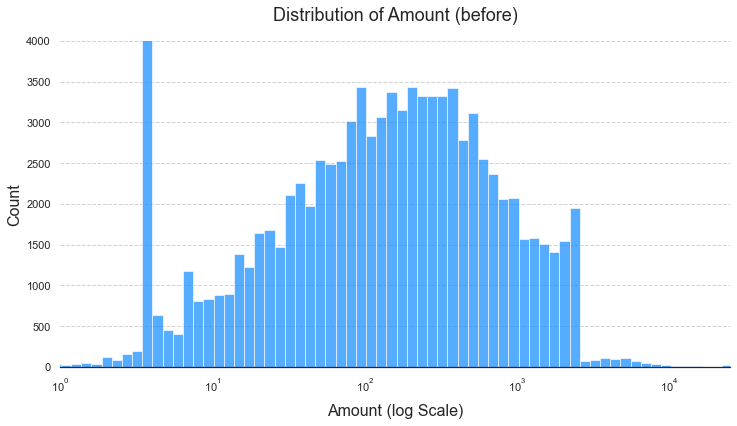

In [63]:
# set seaborn style and color palette
sns.set_style('white')
sns.set_palette('viridis')

# create histogram plot with seaborn

ax = sns.histplot(data['Amount'], bins=100, color='dodgerblue', log_scale=True)
#ax = sns.histplot(data = data[data['amount_okay']]["Amount"], bins=100, color='dodgerblue', log_scale=True)

# set x-axis limits
ax.set_xlim([1, 25000])

# set y-axis limits
ax.set_ylim([0, 4000])

# Customize the grid and the spines
sns.despine(left=True)
ax.grid(axis='y', linestyle='--', alpha=0.9)

# set plot title and axis labels
plt.title('Distribution of Amount (before)',fontsize=18, pad=20)
plt.xlabel('Amount (log Scale)', fontsize=16, labelpad=10)
plt.ylabel('Count', fontsize=16)

# save plot as a file
# plt.savefig('images/amount_dist.png', dpi=300)

# show plot
plt.show()

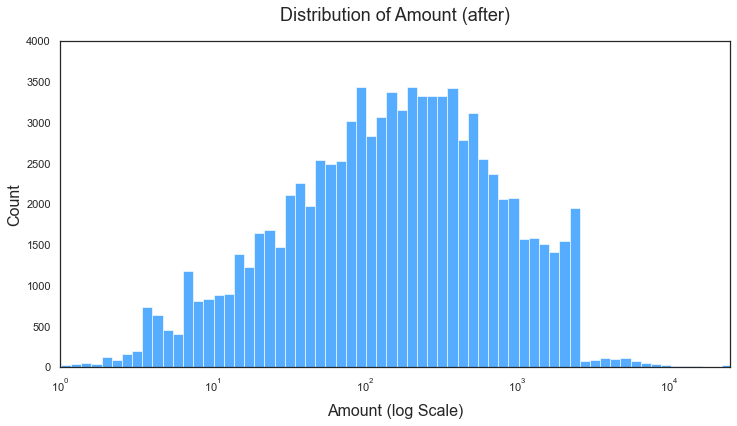

In [64]:
# create histogram plot with seaborn

ax = sns.histplot(data = data[data['amount_okay']]["Amount"], bins=100, color='dodgerblue', log_scale=True)

# set x-axis limits
ax.set_xlim([1, 25000])

# set y-axis limits
ax.set_ylim([0, 4000])

# set plot title and axis labels
plt.title('Distribution of Amount (after)',fontsize=18, pad=20)
plt.xlabel('Amount (log Scale)', fontsize=16, labelpad=10)
plt.ylabel('Count', fontsize=16)

# save plot as a file
# plt.savefig('images/amount_dist_v2.png', dpi=300)

# show plot
plt.show()

In [65]:
## to be safe, check the data type of dates first
df.Date = pd.to_datetime(df.Date)
df.Date.dtypes
## all good

dtype('<M8[ns]')

In [66]:
## find the day of the week
df['Dow'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [67]:
## we want to not use the oot for target encoding variables
train_test = df[df.Date < '2010-11-01']

In [68]:
c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['Dow_Risk'] = df.Dow.map(y_dow_smooth)

In [69]:
y_dow=y_dow.reset_index()
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['Dow']=pd.Categorical(y_dow['Dow'], categories=cats, ordered=True)
y_dow=y_dow.sort_values('Dow')
y_dow=y_dow.set_index('Dow')
y_dow

,Fraud
Dow,
Monday,0.017613
Tuesday,0.017550
Wednesday,0.025234
Thursday,0.027954
Friday,0.031756
Saturday,0.024280
Sunday,0.014008


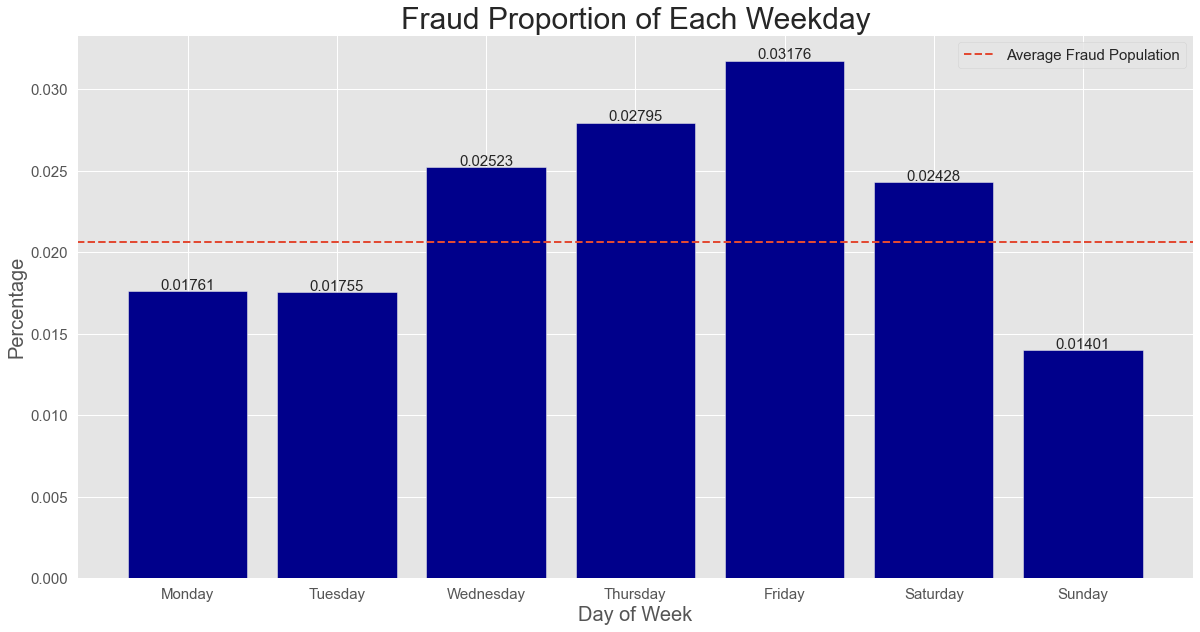

In [70]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow, 
        x = y_dow.index, 
        height = 'Fraud',
        color = 'darkblue'
        )
#ax.set_ylim(bottom = 0.013)
ax.axhline(y = y_avg, ls = '--', lw = 2, label="Average Fraud Population")

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center',fontsize=15)

plt.legend(['Average Fraud Population'], fontsize=15)
plt.xlabel("Day of Week",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Fraud Proportion of Each Weekday", fontsize=30)

plt.show()

In [71]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_Risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.031756
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.031756
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.031756
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.031756
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.031756


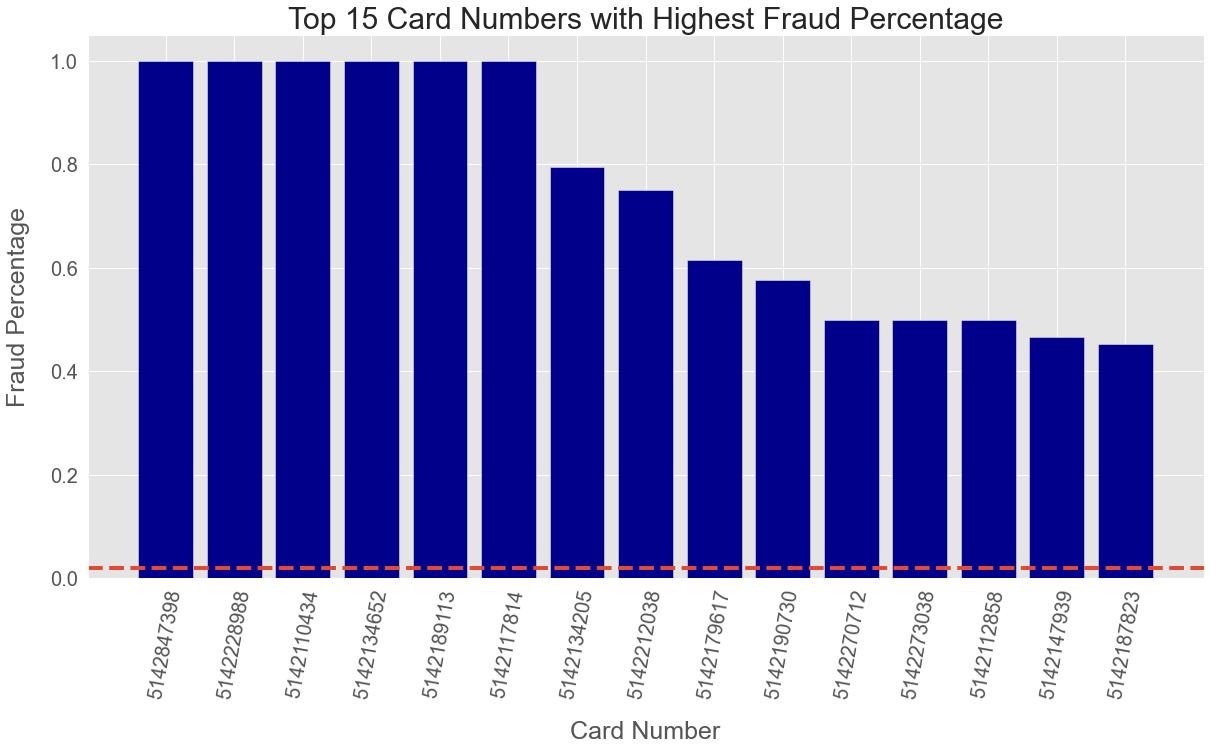

In [72]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_cardnum = train_test.groupby('Cardnum')['Fraud'].mean()
num = train_test.groupby('Cardnum').size()
y_cardnum_smooth = y_avg + (y_cardnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# df['cardnum_risk'] = df['Cardnum'].map(y_cardnum_smooth)
top15_cardnum = pd.DataFrame(y_cardnum\
                             .sort_values(ascending=False).head(15))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_cardnum, x=top15_cardnum.index.astype(str), height='Fraud', color='darkblue')
plt.title('Top 15 Card Numbers with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Card Number',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
plt.xticks(rotation = 80)

ax.axhline(y=y_avg, lw = 4, ls='--')

plt.show()

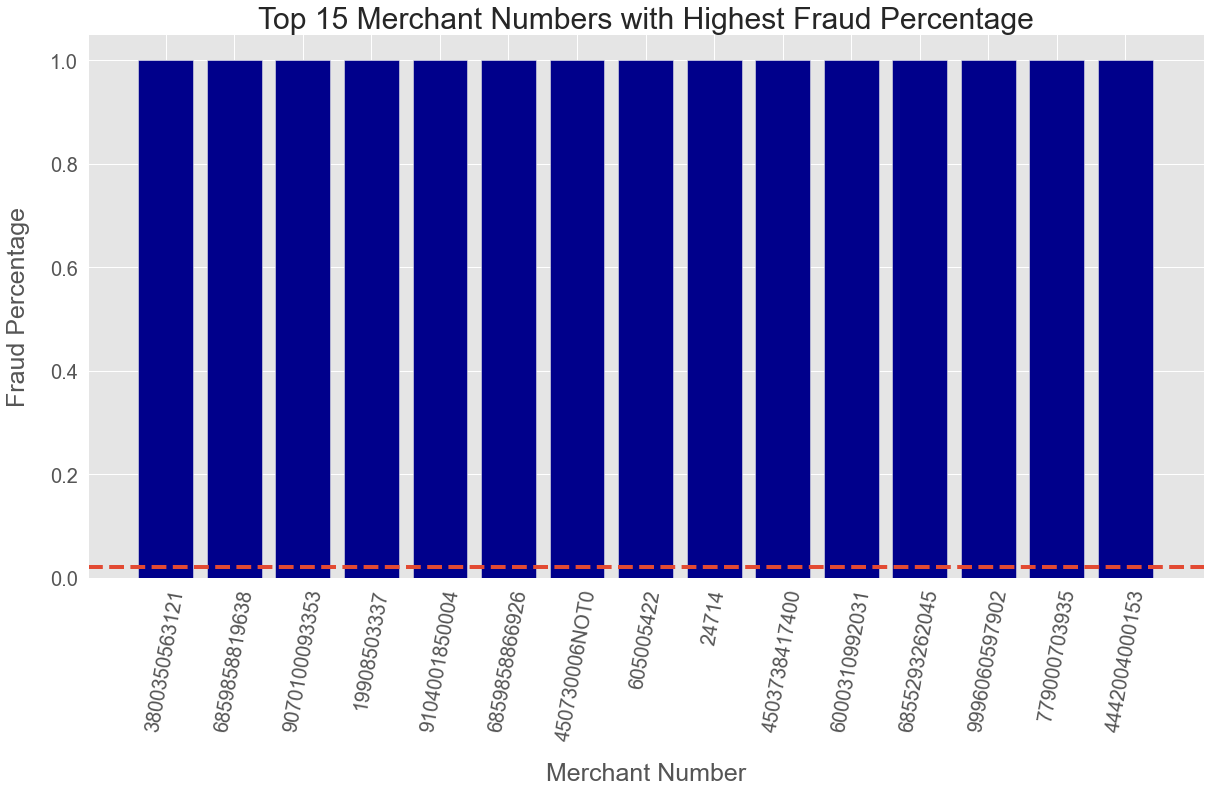

In [73]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_merchnum = train_test.groupby('Merchnum')['Fraud'].mean()
num = train_test.groupby('Merchnum').size()
y_merchnum_smooth = y_avg + (y_merchnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# data['merchnum_risk'] = data['Merchnum'].map(y_merchnum_smooth)
top15_merchnum = pd.DataFrame(y_merchnum\
                             .sort_values(ascending=False).head(15))
top15_merchnum.head(20)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_merchnum, x=top15_merchnum.index.astype(str), height='Fraud', color='darkblue')
plt.title('Top 15 Merchant Numbers with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Merchant Number',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
plt.xticks(rotation = 80)

ax.axhline(y=y_avg, lw = 4, ls='--')

plt.show()

In [74]:
df['Cardnum'] = df['Cardnum'].apply(str)
df['Merchnum'] = df['Merchnum'].apply(str)
df['Merch zip'] = df['Merch zip'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97496 entries, 0 to 97851
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  object        
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           97496 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        97496 non-null  object        
 6   Merch zip          97496 non-null  object        
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  Dow                97496 non-null  object        
 11  Dow_Risk           97496 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 11.7+ MB


In [75]:
### add leading 0 to zips
### note: there are some zips that are state abbrv. as we imputed them ealier, so pandas read the column as str

def leading_0(x):
    
    if '.0' in x:
        x = x[:-2]
        if len(x) == 5:
            return x
        else: 
            return '0'*(5-len(x)) + x
    else:
        return '0'*(5-len(x)) + x

df['Merch zip'] = df['Merch zip'].apply(leading_0)

In [76]:
### delete white spaces in merch description
df['Merch description'] = df['Merch description'].str.replace(r'\s', '')

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/4224219968.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Merch description'] = df['Merch description'].str.replace(r'\s', '')


### Create entities for grouping/linking variables

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97496 entries, 0 to 97851
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  object        
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           97496 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        97496 non-null  object        
 6   Merch zip          97496 non-null  object        
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  Dow                97496 non-null  object        
 11  Dow_Risk           97496 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 11.7+ MB


In [79]:
df['card_merch'] = df['Cardnum'] + df['Merchnum']
df['card_zip'] = df['Cardnum'] + df['Merch zip']
df['card_state'] = df['Cardnum'] + df['Merch state']
df['merch_zip'] = df['Merchnum'] + df['Merch zip']
df['merch_state'] = df['Merchnum'] + df['Merch state']
df['state_des'] = df['Merch state'] + df['Merch description']
df['Card_Merchdesc'] = df['Cardnum'] + df['Merch description']
df['Card_dow'] = df['Cardnum'] + df['Dow']
df['Merchnum_desc'] = df['Merchnum'] + df['Merch description']
df['Merchnum_dow'] = df['Merchnum'] + df['Dow']
df['Merchdesc_dow'] = df['Merch description'] + df['Dow']
df['Card_Merchnum_desc'] = df['Cardnum'] + df['Merchnum'] + df['Merch description']
df['Card_Merchnum_Zip'] = df['Cardnum'] + df['Merchnum'] + df['Merch zip']
df['Card_Merchdesc_Zip'] = df['Cardnum'] + df['Merch description'] + df['Merch zip']
df['Merchnum_desc_State'] = df['Merchnum'] + df['Merch description'] + df['Merch state']
df['Merchnum_desc_Zip'] = df['Merchnum'] + df['Merch description'] + df['Merch zip']
df['merchnum_zip'] = df.Merchnum + df['Merch zip']
df['Merchdesc_State'] = df['Merch description'] + df['Merch state']
df['Merchdesc_Zip'] = df['Merch description'] + df['Merch zip']
df['Card_Merchnum_State'] = df['Cardnum'] + df['Merchnum'] + df['Merch state']
df['Card_Merchdesc_State'] = df['Cardnum'] + df['Merch description'] + df['Merch state']

# you can try adding more entities 
# I think the zip3 entities take a lot of time, same with state_zip

df['zip3'] = df['Merch zip'].str[:3]
df['card_zip3'] = df.Cardnum + df['zip3']
df['state_zip'] = df['Merch state'] + df['Merch zip']
df['merchnum_zip3'] = df.Merchnum + df['zip3']

In [80]:
df.dtypes

Recnum                           int64
Cardnum                         object
Date                    datetime64[ns]
Merchnum                        object
Merch description               object
Merch state                     object
Merch zip                       object
Transtype                       object
Amount                         float64
Fraud                            int64
Dow                             object
Dow_Risk                       float64
card_merch                      object
card_zip                        object
card_state                      object
merch_zip                       object
merch_state                     object
state_des                       object
Card_Merchdesc                  object
Card_dow                        object
Merchnum_desc                   object
Merchnum_dow                    object
Merchdesc_dow                   object
Card_Merchnum_desc              object
Card_Merchnum_Zip               object
Card_Merchdesc_Zip       

In [81]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'card_merch', 'card_zip', 'card_state', 'merch_zip',
       'merch_state', 'state_des', 'Card_Merchdesc', 'Card_dow',
       'Merchnum_desc', 'Merchnum_dow', 'Merchdesc_dow', 'Card_Merchnum_desc',
       'Card_Merchnum_Zip', 'Card_Merchdesc_Zip', 'Merchnum_desc_State',
       'Merchnum_desc_Zip', 'merchnum_zip', 'Merchdesc_State', 'Merchdesc_Zip',
       'Card_Merchnum_State', 'Card_Merchdesc_State', 'zip3', 'card_zip3',
       'state_zip', 'merchnum_zip3'],
      dtype='object')

In [82]:
entities = list(df.iloc[:, np.r_[1, 3, 12:len(df.columns)]].columns)

In [83]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3']

In [84]:
# if the number in any entity group is really low it won't be a good linking entity
ent_2_remove = []
for ent in entities:
    num = len(df.groupby(ent))
    print(ent, num)
    if num <= 10:
        print('remove',ent)
        ent_2_remove.append(ent)
    else:
        print('ok',ent)
        
ent_2_remove

Cardnum 1643
ok Cardnum
Merchnum 13605
ok Merchnum
card_merch 40220
ok card_merch
card_zip 33837
ok card_zip
card_state 15971
ok card_state
merch_zip 13844
ok merch_zip
merch_state 13672
ok merch_state
state_des 13227
ok state_des
Card_Merchdesc 43164
ok Card_Merchdesc
Card_dow 9182
ok Card_dow
Merchnum_desc 14588
ok Merchnum_desc
Merchnum_dow 27816
ok Merchnum_dow
Merchdesc_dow 27738
ok Merchdesc_dow
Card_Merchnum_desc 45350
ok Card_Merchnum_desc
Card_Merchnum_Zip 40426
ok Card_Merchnum_Zip
Card_Merchdesc_Zip 43503
ok Card_Merchdesc_Zip
Merchnum_desc_State 14630
ok Merchnum_desc_State
Merchnum_desc_Zip 14791
ok Merchnum_desc_Zip
merchnum_zip 13844
ok merchnum_zip
Merchdesc_State 13227
ok Merchdesc_State
Merchdesc_Zip 13515
ok Merchdesc_Zip
Card_Merchnum_State 40250
ok Card_Merchnum_State
Card_Merchdesc_State 43262
ok Card_Merchdesc_State
zip3 701
ok zip3
card_zip3 26218
ok card_zip3
state_zip 4701
ok state_zip
merchnum_zip3 13773
ok merchnum_zip3


[]

In [85]:
df.drop(columns=ent_2_remove,inplace=True)
entities = [i for i in entities if i not in ent_2_remove]
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3']

In [86]:
icols = 0
for col in data.columns:
    print(icols, col)
    icols = icols+1

0 Recnum
1 Cardnum
2 Date
3 Merchnum
4 Merch description
5 Merch state
6 Merch zip
7 Transtype
8 Amount
9 Fraud
10 amount_okay


In [87]:
# The dataframe 'final' will be our variables
df.Date = pd.to_datetime(df.Date)
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

## Identify categorical fields for Target Encoding

In [88]:
df.nunique()

Recnum                  97496
Cardnum                  1643
Date                      365
Merchnum                13605
Merch description       12944
Merch state                55
Merch zip                4580
Transtype                   1
Amount                  35310
Fraud                       2
Dow                         7
Dow_Risk                    7
card_merch              40220
card_zip                33837
card_state              15971
merch_zip               13844
merch_state             13672
state_des               13227
Card_Merchdesc          43164
Card_dow                 9182
Merchnum_desc           14588
Merchnum_dow            27816
Merchdesc_dow           27738
Card_Merchnum_desc      45350
Card_Merchnum_Zip       40426
Card_Merchdesc_Zip      43503
Merchnum_desc_State     14630
Merchnum_desc_Zip       14791
merchnum_zip            13844
Merchdesc_State         13227
Merchdesc_Zip           13515
Card_Merchnum_State     40250
Card_Merchdesc_State    43262
zip3      

In [89]:
# For TE we want the cardinality to be not too high. 
# We're basically giving a "black mark" to any category value that has had high fraud in the past.

col_TE = ['Merch state','Merch zip','Dow']

In [90]:
# Now make the TE variables
TE = TargetEncoder()
data_cat_TE = df[col_TE]
data_cat_TE.head()

,Merch state,Merch zip,Dow
0,TN,38118,Friday
1,MA,01803,Friday
2,MD,20706,Friday
3,TN,38118,Friday
4,TN,38118,Friday


In [91]:
data_cat_TE_Xtrntst = train_test[col_TE]
TE.fit(data_cat_TE_Xtrntst,train_test['Fraud'])
temp1 = TE.transform(data_cat_TE)
temp1.shape

(97496, 3)

In [92]:
temp1.head()

,Merch state,Merch zip,Dow
0,0.017176,0.020604,0.031756
1,0.015752,0.020604,0.031756
2,0.028553,0.020604,0.031756
3,0.017176,0.020604,0.031756
4,0.017176,0.020604,0.031756


In [93]:
temp1.isna().sum()

Merch state    0
Merch zip      0
Dow            0
dtype: int64

In [94]:
for col in temp1.columns:
      temp1.rename(columns={col:col + '_TE'}, inplace=True)

temp1.head()

,Merch state_TE,Merch zip_TE,Dow_TE
0,0.017176,0.020604,0.031756
1,0.015752,0.020604,0.031756
2,0.028553,0.020604,0.031756
3,0.017176,0.020604,0.031756
4,0.017176,0.020604,0.031756


In [95]:
print('before the TE variables:',final.shape)
final = pd.concat([final,temp1], axis = 1)
print('after the TE variables:',final.shape)

before the TE variables: (97496, 37)
after the TE variables: (97496, 40)


In [96]:
temp2 = pd.concat([data_cat_TE,temp1], axis = 1)
print(temp2.shape)
temp2.head()

(97496, 6)


,Merch state,Merch zip,Dow,Merch state_TE,Merch zip_TE,Dow_TE
0,TN,38118,Friday,0.017176,0.020604,0.031756
1,MA,01803,Friday,0.015752,0.020604,0.031756
2,MD,20706,Friday,0.028553,0.020604,0.031756
3,TN,38118,Friday,0.017176,0.020604,0.031756
4,TN,38118,Friday,0.017176,0.020604,0.031756


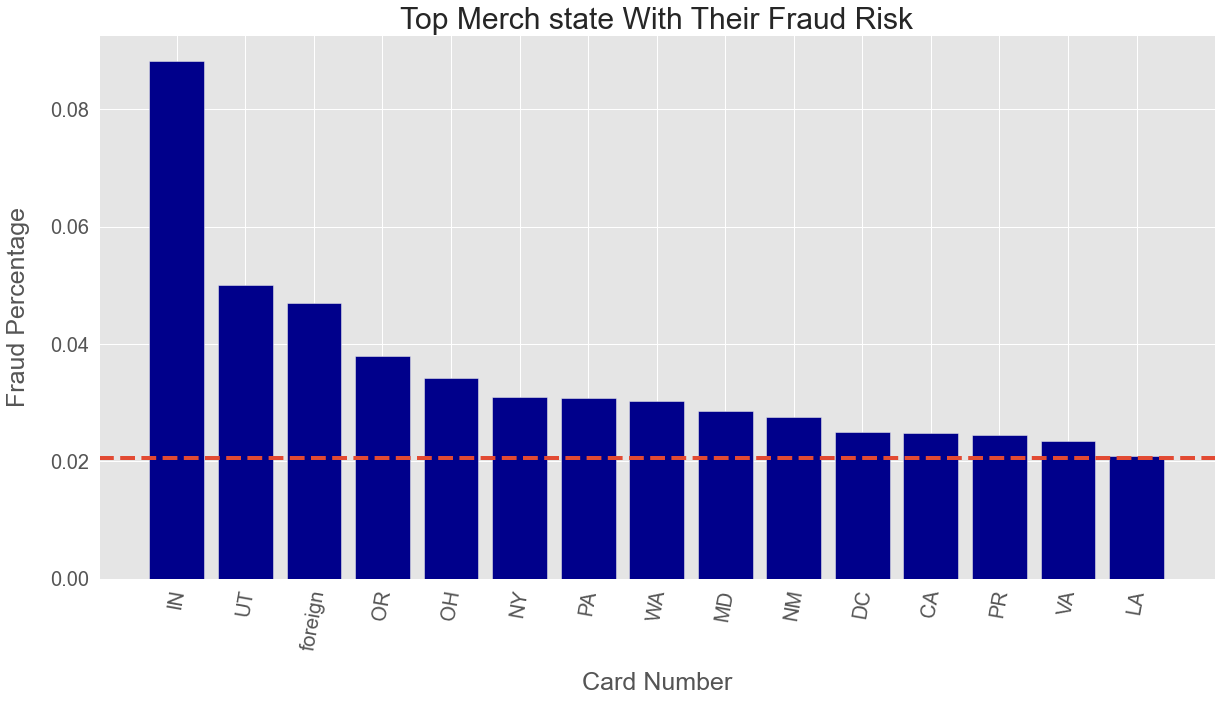

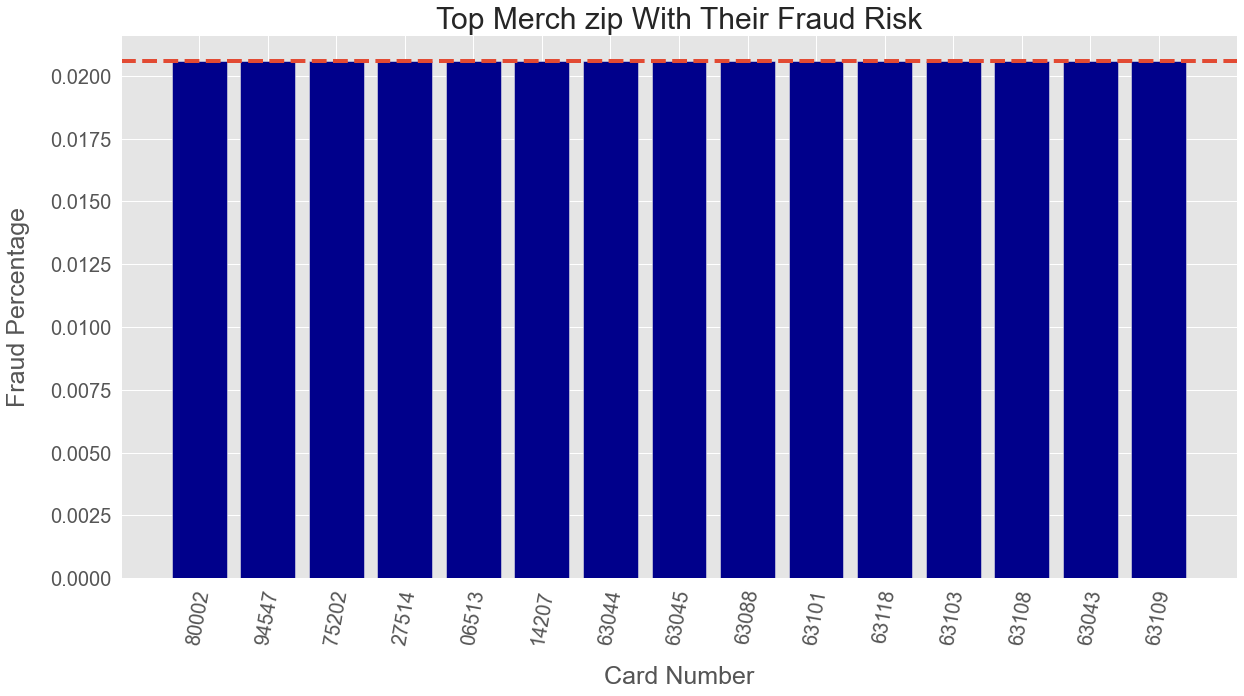

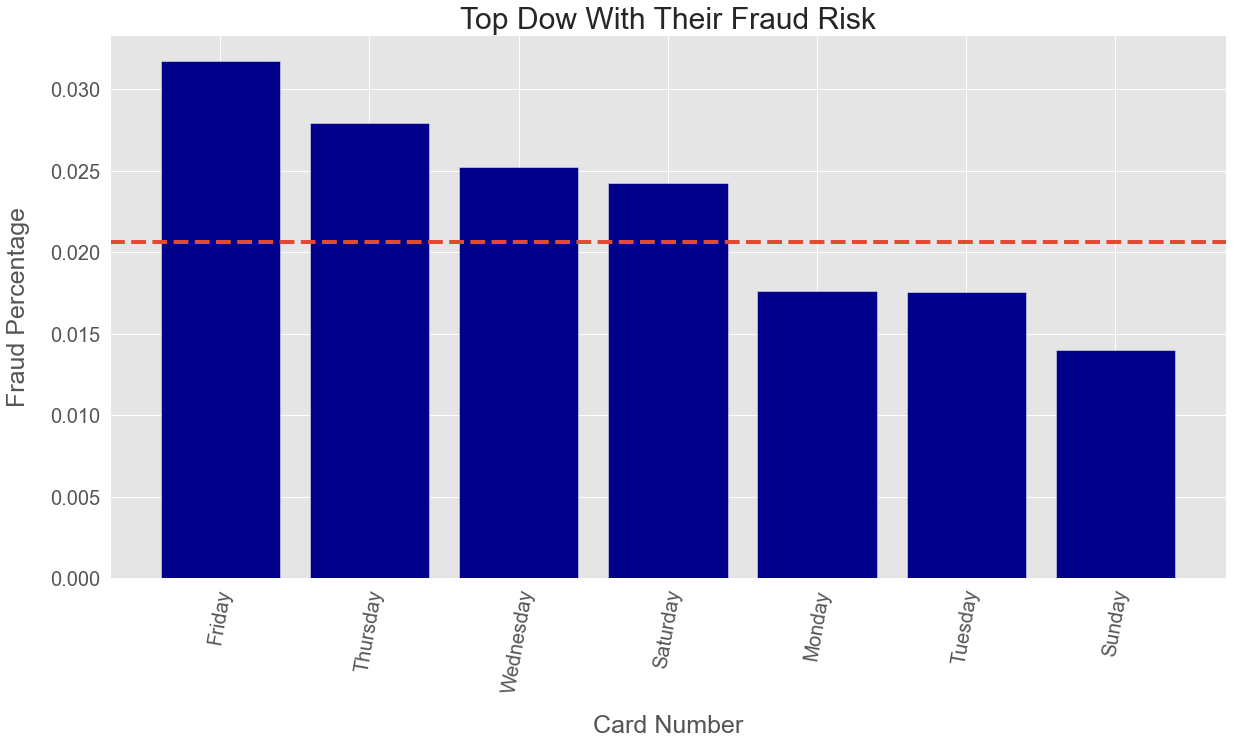

In [97]:
for col in col_TE:
    temp3 = temp2.groupby(col)[col+'_TE'].mean()
    toplist = pd.DataFrame(temp3.sort_values(ascending=False).head(15))
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(20,10))
    plt.bar(data=toplist, x=toplist.index.astype(str), height=col+'_TE', color='darkblue')
    plt.title('Top '+col+' With Their Fraud Risk', fontsize=30)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Card Number',fontsize=25, labelpad=20)
    plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
    plt.xticks(rotation = 80)

    ax.axhline(y=y_avg, lw = 4, ls='--')

    plt.show()

## Make the Benford's law top 40 tables and variables

In [98]:
# another way to get the first digit
bf = data.copy()
bf['amount_100'] = (bf['Amount'] * 100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
bf['first_digit'].value_counts()

1    26940
3    18816
2    16368
4     8379
5     7027
6     6099
7     5087
8     4594
9     4186
Name: first_digit, dtype: int64

In [99]:
# dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
dropfedex = bf[bf['amount_okay']==False]
dropfedex.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay,amount_100,first_digit
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
5,6,5142149874,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.67,0,False,367.0,3
6,7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3


In [100]:
droplist = dropfedex.index.tolist()
droplist[:10]

[0, 3, 4, 5, 6, 9, 10, 11, 15, 16]

In [101]:
droplist[-10:]

[97231, 97238, 97307, 97333, 97345, 97391, 97418, 97496, 97525, 97558]

In [102]:
len(droplist)

7592

In [103]:
bf.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay,amount_100,first_digit
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,True,3142.0,3
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,True,17849.0,1
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3


In [104]:
bf.shape

(97496, 13)

In [105]:
bf1 = bf.drop(droplist)
bf1.shape

(89904, 13)

In [106]:
# datefilter = datetime.datetime(2010,11,1)
# bf1 = bf1[bf1['Date'] < datefilter]
# bf1.shape

In [107]:
bf1['bin']= bf1['first_digit'].apply(lambda x: "low" if x == "1" else ("low" if x == "2" else "high"))
bf1.head(5)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay,amount_100,first_digit,bin
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,True,3142.0,3,high
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,True,17849.0,1,low
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,True,23032.0,2,low
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,True,6211.0,6,high
12,13,5142146134,2010-01-01,5509006296254,FEDEX SHP 12/21/09 AB#,TN,38118.0,P,3.85,0,True,385.0,3,high


In [108]:
bf1['first_digit'].value_counts()

1    26940
2    16368
3    11224
4     8379
5     7027
6     6099
7     5087
8     4594
9     4186
Name: first_digit, dtype: int64

In [109]:
# calculating n_low and n_high
card_bf =  bf1.groupby(['Cardnum','bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns=['Cardnum', 'bin', 'count']
card_bf

,Cardnum,bin,count
0,5142110002,low,1
1,5142110081,high,4
2,5142110313,high,1
3,5142110313,low,2
4,5142110402,high,8
...,...,...,...
3132,5142310598,low,2
3133,5142310768,high,2
3134,5142310768,low,2
3135,5142847398,high,35


In [110]:
card_bf =  card_bf.pivot_table(index='Cardnum',columns='bin',values='count',aggfunc='sum').reset_index()
card_bf.columns=['Cardnum', 'n_high', 'n_low']
card_bf

,Cardnum,n_high,n_low
0,5142110002,NaN,1.0
1,5142110081,4.0,NaN
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,NaN,1.0
...,...,...,...
1637,5142310397,1.0,NaN
1638,5142310525,3.0,1.0
1639,5142310598,NaN,2.0
1640,5142310768,2.0,2.0


In [111]:
# if either n_low or n_high is zero, set it to 1
card_bf = card_bf.fillna(1)
card_bf

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0
...,...,...,...
1637,5142310397,1.0,1.0
1638,5142310525,3.0,1.0
1639,5142310598,1.0,2.0
1640,5142310768,2.0,2.0


In [112]:
# calclating R, 1/R, U, n, t U_smoothed
c=3
n_mid=15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x, y : max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n']-n_mid)/c)
card_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),card_bf['U'],card_bf['t']))

In [113]:
top40_card_bf = card_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_card_bf.head(40)

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142253356,5.0,61.0,13.371200,0.074788,13.371200,66.0,17.000000,13.371199
1,5142299634,65.0,7.0,0.118031,8.472367,8.472367,72.0,19.000000,8.472367
2,5142197563,134.0,16.0,0.130866,7.641423,7.641423,150.0,45.000000,7.641423
3,5142194617,33.0,5.0,0.166061,6.021898,6.021898,38.0,7.666667,6.019548
4,5142297710,135.0,22.0,0.178607,5.598872,5.598872,157.0,47.333333,5.598872
5,5142288241,13.0,1.0,0.084308,11.861314,11.861314,14.0,-0.333333,5.533836
6,5142239140,3.0,16.0,5.845333,0.171077,5.845333,19.0,1.333333,4.834555
7,5142144931,30.0,6.0,0.219200,4.562044,4.562044,36.0,7.000000,4.558799
8,5142148452,450.0,99.0,0.241120,4.147313,4.147313,549.0,178.000000,4.147313
9,5142192606,2.0,13.0,7.124000,0.140371,7.124000,15.0,0.000000,4.062000


In [114]:
# calculating n_low and n_high
merch_bf =  bf1.groupby(['Merchnum','bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns=['Merchnum', 'bin', 'count']
merch_bf =  merch_bf.pivot_table(index='Merchnum',columns='bin',values='count',aggfunc='sum').reset_index()
merch_bf.columns=['Merchnum', 'n_high', 'n_low']
merch_bf.head()

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,NaN
1,004740006ABC6,NaN,1.0
2,005590006PNB6,1.0,NaN
3,014430619 14,NaN,1.0
4,014938913 51,1.0,NaN


In [115]:
# if either n_low or n_high is zero, set it to 1
merch_bf = merch_bf.fillna(1)
merch_bf

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,1.0
1,004740006ABC6,1.0,1.0
2,005590006PNB6,1.0,1.0
3,014430619 14,1.0,1.0
4,014938913 51,1.0,1.0
...,...,...,...
13600,DU49038320006,1.0,1.0
13601,JCPENNE9 CO,2.0,1.0
13602,PENNE9 CO #05,1.0,1.0
13603,PENNE9 CO #68,1.0,1.0


In [116]:
# calclating R, 1/R, U, n, t U_smoothed
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x, y : max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n']-n_mid)/c)
merch_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),merch_bf['U'],merch_bf['t']))

In [117]:
top40_merch_bf = merch_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_merch_bf.head(40)

,Merchnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,991808369338,184.0,1.0,0.005957,167.883212,167.883212,185.0,56.666667,167.883212
1,308904389335,53.0,1.0,0.020679,48.357664,48.357664,54.0,13.000000,48.357557
2,3523000628102,1.0,34.0,37.264000,0.026836,37.264000,35.0,6.666667,37.217908
3,55158027,1.0,27.0,29.592000,0.033793,29.592000,28.0,4.333333,29.221627
4,8916500620062,31.0,1.0,0.035355,28.284672,28.284672,32.0,5.666667,28.190609
5,3910694900001,1.0,25.0,27.400000,0.036496,27.400000,26.0,3.666667,26.741995
6,881145544,1.0,24.0,26.304000,0.038017,26.304000,25.0,3.333333,25.432399
7,6844000608436,1.0,23.0,25.208000,0.039670,25.208000,24.0,3.000000,24.059914
8,8078200641472,3.0,59.0,21.554667,0.046394,21.554667,62.0,15.666667,21.554663
9,92891948003,24.0,1.0,0.045667,21.897810,21.897810,25.0,3.333333,21.177981


In [118]:
# Here are the tables for the Benford's law. They would be useful for a forensic analysis
top40_card_bf.to_csv('Benford top cards.csv')
top40_merch_bf.to_csv('Benford top merchs.csv')

In [119]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)
card_bf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Cardnum     1642 non-null   object 
 1   n_high      1642 non-null   float64
 2   n_low       1642 non-null   float64
 3   R           1642 non-null   float64
 4   1/R         1642 non-null   float64
 5   U           1642 non-null   float64
 6   n           1642 non-null   float64
 7   t           1642 non-null   float64
 8   U_smoothed  1642 non-null   float64
dtypes: float64(8), object(1)
memory usage: 115.6+ KB


In [120]:
card_bf.set_index('Cardnum',inplace=True)

In [121]:
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'], ascending = False).head(10)

,U_smoothed
Cardnum,
5142253356,13.371199
5142299634,8.472367
5142197563,7.641423
5142194617,6.019548
5142297710,5.598872
5142288241,5.533836
5142239140,4.834555
5142144931,4.558799
5142148452,4.147313


In [122]:
merch_bf.set_index('Merchnum',inplace=True)

In [123]:
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'], ascending = False).head(10)

,U_smoothed
Merchnum,
991808369338,167.883212
308904389335,48.357557
3523000628102,37.217908
55158027,29.221627
8916500620062,28.190609
3910694900001,26.741995
881145544,25.432399
6844000608436,24.059914
8078200641472,21.554663


In [124]:
final = final.merge(card_Ustar, how = 'left',left_on='Cardnum',right_on=card_Ustar.index)
final = final.rename(columns={'U_smoothed':'U*_cardnum'})
final = final.merge(merch_Ustar, how = 'left',left_on='Merchnum',right_on=merch_Ustar.index)
final = final.rename(columns={'U_smoothed':'U*_merchnum'})

In [125]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_Merchdesc_State,zip3,card_zip3,state_zip,merchnum_zip3,Merch state_TE,Merch zip_TE,Dow_TE,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,5142190439FEDEXSHP12/23/09AB#TN,381,5142190439381,TN38118,5509006296254381,0.017176,0.020604,0.031756,1.675514,3.088884
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,01803,P,31.42,0,...,5142183973SERVICEMERCHANDISE#81MA,018,5142183973018,MA01803,61003026333018,0.015752,0.020604,0.031756,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706,P,178.49,0,...,5142131721OFFICEDEPOT#191MD,207,5142131721207,MD20706,4503082993600207,0.028553,0.020604,0.031756,2.073514,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118,P,3.62,0,...,5142148452FEDEXSHP12/28/09AB#TN,381,5142148452381,TN38118,5509006296254381,0.017176,0.020604,0.031756,4.147313,3.088884
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,5142190439FEDEXSHP12/23/09AB#TN,381,5142190439381,TN38118,5509006296254381,0.017176,0.020604,0.031756,1.675514,3.088884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97491,97848,5142276053,2010-12-31,3500000006160,BESTBUY00001610,KY,41042,P,84.79,0,...,5142276053BESTBUY00001610KY,410,5142276053410,KY41042,3500000006160410,0.007009,0.020604,0.031756,1.002393,1.001244
97492,97849,5142225701,2010-12-31,8090710030950,MARKUSOFFICESUPPLIES,OH,45248,P,118.75,0,...,5142225701MARKUSOFFICESUPPLIESOH,452,5142225701452,OH45248,8090710030950452,0.034242,0.020604,0.031756,1.137948,1.216518
97493,97850,5142226486,2010-12-31,4503057341100,"TECHPAC,INC",OH,45150,P,363.56,0,...,"5142226486TECHPAC,INCOH",451,5142226486451,OH45150,4503057341100451,0.034242,0.020604,0.031756,1.216545,1.096000
97494,97851,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,...,5142244619BUY.COMCA,926,5142244619926,CA92656,8834000695412926,0.024843,0.020604,0.031756,1.499767,1.034129


In [126]:
final['U*_cardnum'].isna().sum()

3

In [127]:
final['U*_merchnum'].isna().sum()

0

In [128]:
final['U*_cardnum'].fillna(1,inplace=True)
final['U*_merchnum'].fillna(1,inplace=True)

In [129]:
final['U*_cardnum'].isna().sum()

0

In [130]:
final['U*_merchnum'].isna().sum()

0

In [131]:
print(final.shape)
final.drop(columns=['U*_cardnum','U*_merchnum'],inplace=True)
print(final.shape)

(97496, 42)
(97496, 40)


In [132]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merchdesc_Zip,Card_Merchnum_State,Card_Merchdesc_State,zip3,card_zip3,state_zip,merchnum_zip3,Merch state_TE,Merch zip_TE,Dow_TE
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,FEDEXSHP12/23/09AB#38118,51421904395509006296254TN,5142190439FEDEXSHP12/23/09AB#TN,381,5142190439381,TN38118,5509006296254381,0.017176,0.020604,0.031756
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,01803,P,31.42,0,...,SERVICEMERCHANDISE#8101803,514218397361003026333MA,5142183973SERVICEMERCHANDISE#81MA,018,5142183973018,MA01803,61003026333018,0.015752,0.020604,0.031756
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706,P,178.49,0,...,OFFICEDEPOT#19120706,51421317214503082993600MD,5142131721OFFICEDEPOT#191MD,207,5142131721207,MD20706,4503082993600207,0.028553,0.020604,0.031756
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118,P,3.62,0,...,FEDEXSHP12/28/09AB#38118,51421484525509006296254TN,5142148452FEDEXSHP12/28/09AB#TN,381,5142148452381,TN38118,5509006296254381,0.017176,0.020604,0.031756
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,FEDEXSHP12/23/09AB#38118,51421904395509006296254TN,5142190439FEDEXSHP12/23/09AB#TN,381,5142190439381,TN38118,5509006296254381,0.017176,0.020604,0.031756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97491,97848,5142276053,2010-12-31,3500000006160,BESTBUY00001610,KY,41042,P,84.79,0,...,BESTBUY0000161041042,51422760533500000006160KY,5142276053BESTBUY00001610KY,410,5142276053410,KY41042,3500000006160410,0.007009,0.020604,0.031756
97492,97849,5142225701,2010-12-31,8090710030950,MARKUSOFFICESUPPLIES,OH,45248,P,118.75,0,...,MARKUSOFFICESUPPLIES45248,51422257018090710030950OH,5142225701MARKUSOFFICESUPPLIESOH,452,5142225701452,OH45248,8090710030950452,0.034242,0.020604,0.031756
97493,97850,5142226486,2010-12-31,4503057341100,"TECHPAC,INC",OH,45150,P,363.56,0,...,"TECHPAC,INC45150",51422264864503057341100OH,"5142226486TECHPAC,INCOH",451,5142226486451,OH45150,4503057341100451,0.034242,0.020604,0.031756
97494,97851,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,...,BUY.COM92656,51422446198834000695412CA,5142244619BUY.COMCA,926,5142244619926,CA92656,8834000695412926,0.024843,0.020604,0.031756


In [133]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3']

In [134]:
numstart = len(final.columns) - 9
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 40)
# new variables is  9


In [135]:
%%time
start = timeit.default_timer()
for entity in entities:    
    try: print(entity,'Run time for the this entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    

# Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2006-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')  
    
# Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp1
    del temp2
    del mapper2  

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))



Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Merchnum Run time for the this entity ----------------- 4.674818625000626s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchnum_count_14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchnum_count_30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchnum_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum amount variables over past 60 ---> Done
card_merch Run time for the this entity ----------------- 35.645115749999604s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


card_merch_day_since ---> Done
card_merch_count_0 ---> Done
card_merch amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_merch_count_1 ---> Done
card_merch amount variables over past 1 ---> Done
card_merch_count_3 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_merch amount variables over past 3 ---> Done
card_merch_count_7 ---> Done
card_merch amount variables over past 7 ---> Done


<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_merch_count_14 ---> Done
card_merch amount variables over past 14 ---> Done


<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_merch_count_30 ---> Done
card_merch amount variables over past 30 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_merch_count_60 ---> Done
card_merch amount variables over past 60 ---> Done
card_zip Run time for the this entity ----------------- 1.6024770839994744s


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


card_zip_day_since ---> Done
card_zip_count_0 ---> Done
card_zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip_count_1 ---> Done
card_zip amount variables over past 1 ---> Done
card_zip_count_3 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip amount variables over past 3 ---> Done
card_zip_count_7 ---> Done
card_zip amount variables over past 7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip_count_14 ---> Done
card_zip amount variables over past 14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip_count_30 ---> Done
card_zip amount variables over past 30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip_count_60 ---> Done
card_zip amount variables over past 60 ---> Done
card_state Run time for the this entity ----------------- 1.8067585410008178s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


card_state_day_since ---> Done
card_state_count_0 ---> Done
card_state amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_state_count_1 ---> Done
card_state amount variables over past 1 ---> Done
card_state_count_3 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_state amount variables over past 3 ---> Done
card_state_count_7 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_state amount variables over past 7 ---> Done
card_state_count_14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_state amount variables over past 14 ---> Done
card_state_count_30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_state amount variables over past 30 ---> Done
card_state_count_60 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_state amount variables over past 60 ---> Done
merch_zip Run time for the this entity ----------------- 2.0851508750001813s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



merch_zip_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip_count_0 ---> Done
merch_zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip_count_1 ---> Done
merch_zip amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip_count_3 ---> Done
merch_zip amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_zip_count_7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_zip_count_14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_zip_count_30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_zip_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_zip amount variables over past 60 ---> Done
merch_state Run time for the this entity ----------------- 36.52492712499952s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



merch_state_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state_count_0 ---> Done
merch_state amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state_count_1 ---> Done
merch_state amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state_count_3 ---> Done


<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_state amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_state_count_7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_state_count_14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_state_count_30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merch_state_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merch_state amount variables over past 60 ---> Done
state_des Run time for the this entity ----------------- 35.67963691600016s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



state_des_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des_count_0 ---> Done
state_des amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des_count_1 ---> Done
state_des amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des_count_3 ---> Done
state_des amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des_count_7 ---> Done
state_des amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des_count_14 ---> Done
state_des amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des_count_30 ---> Done


<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_des amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_des_count_60 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_des amount variables over past 60 ---> Done
Card_Merchdesc Run time for the this entity ----------------- 4.478306458999214s

Card_Merchdesc_day_since ---> Done
Card_Merchdesc_count_0 ---> Done


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc amount variables over past 0 ---> Done
Card_Merchdesc_count_1 ---> Done
Card_Merchdesc amount variables over past 1 ---> Done
Card_Merchdesc_count_3 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc amount variables over past 3 ---> Done
Card_Merchdesc_count_7 ---> Done
Card_Merchdesc amount variables over past 7 ---> Done
Card_Merchdesc_count_14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc amount variables over past 14 ---> Done
Card_Merchdesc_count_30 ---> Done
Card_Merchdesc amount variables over past 30 ---> Done
Card_Merchdesc_count_60 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc amount variables over past 60 ---> Done
Card_dow Run time for the this entity ----------------- 1.0618844580003497s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Card_dow_day_since ---> Done
Card_dow_count_0 ---> Done
Card_dow amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_dow_count_1 ---> Done
Card_dow amount variables over past 1 ---> Done
Card_dow_count_3 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_dow amount variables over past 3 ---> Done
Card_dow_count_7 ---> Done
Card_dow amount variables over past 7 ---> Done


<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_dow_count_14 ---> Done
Card_dow amount variables over past 14 ---> Done


<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_dow_count_30 ---> Done
Card_dow amount variables over past 30 ---> Done


<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_dow_count_60 ---> Done
Card_dow amount variables over past 60 ---> Done
Merchnum_desc Run time for the this entity ----------------- 1.554253542000879s


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Merchnum_desc_day_since ---> Done
Merchnum_desc_count_0 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_count_1 ---> Done
Merchnum_desc amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_count_3 ---> Done
Merchnum_desc amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_count_7 ---> Done
Merchnum_desc amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_count_14 ---> Done
Merchnum_desc amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_count_30 ---> Done
Merchnum_desc amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_count_60 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc amount variables over past 60 ---> Done
Merchnum_dow Run time for the this entity ----------------- 3.9965274589994806s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Merchnum_dow_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow_count_0 ---> Done
Merchnum_dow amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow_count_1 ---> Done
Merchnum_dow amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow_count_3 ---> Done
Merchnum_dow amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow_count_7 ---> Done
Merchnum_dow amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow_count_14 ---> Done
Merchnum_dow amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow_count_30 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchnum_dow_count_60 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_dow amount variables over past 60 ---> Done
Merchdesc_dow Run time for the this entity ----------------- 4.869911750000028s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Merchdesc_dow_day_since ---> Done
Merchdesc_dow_count_0 ---> Done
Merchdesc_dow amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_dow_count_1 ---> Done
Merchdesc_dow amount variables over past 1 ---> Done
Merchdesc_dow_count_3 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_dow amount variables over past 3 ---> Done
Merchdesc_dow_count_7 ---> Done
Merchdesc_dow amount variables over past 7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_dow_count_14 ---> Done
Merchdesc_dow amount variables over past 14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_dow_count_30 ---> Done
Merchdesc_dow amount variables over past 30 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_dow_count_60 ---> Done
Merchdesc_dow amount variables over past 60 ---> Done
Card_Merchnum_desc Run time for the this entity ----------------- 1.6547908339998685s


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Card_Merchnum_desc_day_since ---> Done
Card_Merchnum_desc_count_0 ---> Done
Card_Merchnum_desc amount variables over past 0 ---> Done
Card_Merchnum_desc_count_1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_desc amount variables over past 1 ---> Done
Card_Merchnum_desc_count_3 ---> Done
Card_Merchnum_desc amount variables over past 3 ---> Done
Card_Merchnum_desc_count_7 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_desc amount variables over past 7 ---> Done
Card_Merchnum_desc_count_14 ---> Done
Card_Merchnum_desc amount variables over past 14 ---> Done
Card_Merchnum_desc_count_30 ---> Done


<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_desc amount variables over past 30 ---> Done
Card_Merchnum_desc_count_60 ---> Done
Card_Merchnum_desc amount variables over past 60 ---> Done
Card_Merchnum_Zip Run time for the this entity ----------------- 1.0436282079990633s


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Card_Merchnum_Zip_day_since ---> Done
Card_Merchnum_Zip_count_0 ---> Done
Card_Merchnum_Zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_Zip_count_1 ---> Done
Card_Merchnum_Zip amount variables over past 1 ---> Done
Card_Merchnum_Zip_count_3 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_Zip amount variables over past 3 ---> Done
Card_Merchnum_Zip_count_7 ---> Done
Card_Merchnum_Zip amount variables over past 7 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_Zip_count_14 ---> Done
Card_Merchnum_Zip amount variables over past 14 ---> Done


<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_Zip_count_30 ---> Done
Card_Merchnum_Zip amount variables over past 30 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_Zip_count_60 ---> Done
Card_Merchnum_Zip amount variables over past 60 ---> Done
Card_Merchdesc_Zip Run time for the this entity ----------------- 1.5802402079989406s


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Card_Merchdesc_Zip_day_since ---> Done
Card_Merchdesc_Zip_count_0 ---> Done
Card_Merchdesc_Zip amount variables over past 0 ---> Done
Card_Merchdesc_Zip_count_1 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_Zip amount variables over past 1 ---> Done
Card_Merchdesc_Zip_count_3 ---> Done
Card_Merchdesc_Zip amount variables over past 3 ---> Done
Card_Merchdesc_Zip_count_7 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_Zip amount variables over past 7 ---> Done
Card_Merchdesc_Zip_count_14 ---> Done
Card_Merchdesc_Zip amount variables over past 14 ---> Done
Card_Merchdesc_Zip_count_30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_Zip amount variables over past 30 ---> Done
Card_Merchdesc_Zip_count_60 ---> Done
Card_Merchdesc_Zip amount variables over past 60 ---> Done
Merchnum_desc_State Run time for the this entity ----------------- 1.0334047920005105s


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Merchnum_desc_State_day_since ---> Done
Merchnum_desc_State_count_0 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State_count_1 ---> Done
Merchnum_desc_State amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State_count_3 ---> Done
Merchnum_desc_State amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State_count_7 ---> Done
Merchnum_desc_State amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State_count_14 ---> Done
Merchnum_desc_State amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State_count_30 ---> Done
Merchnum_desc_State amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State_count_60 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_State amount variables over past 60 ---> Done
Merchnum_desc_Zip Run time for the this entity ----------------- 3.979617667000639s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Merchnum_desc_Zip_day_since ---> Done
Merchnum_desc_Zip_count_0 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip_count_1 ---> Done
Merchnum_desc_Zip amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip_count_3 ---> Done
Merchnum_desc_Zip amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip_count_7 ---> Done
Merchnum_desc_Zip amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip_count_14 ---> Done
Merchnum_desc_Zip amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip_count_30 ---> Done
Merchnum_desc_Zip amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip_count_60 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchnum_desc_Zip amount variables over past 60 ---> Done
merchnum_zip Run time for the this entity ----------------- 3.960375083001054s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



merchnum_zip_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip_count_0 ---> Done
merchnum_zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip_count_1 ---> Done
merchnum_zip amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip_count_3 ---> Done
merchnum_zip amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip_count_7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip_count_14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip_count_30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip amount variables over past 60 ---> Done
Merchdesc_State Run time for the this entity ----------------- 34.98337508300028s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Merchdesc_State_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State_count_0 ---> Done
Merchdesc_State amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State_count_1 ---> Done
Merchdesc_State amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State_count_3 ---> Done
Merchdesc_State amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State_count_7 ---> Done
Merchdesc_State amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State_count_14 ---> Done
Merchdesc_State amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State_count_30 ---> Done


<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchdesc_State amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchdesc_State_count_60 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_State amount variables over past 60 ---> Done
Merchdesc_Zip Run time for the this entity ----------------- 4.459384916999625s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Merchdesc_Zip_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip_count_0 ---> Done
Merchdesc_Zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip_count_1 ---> Done
Merchdesc_Zip amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip_count_3 ---> Done
Merchdesc_Zip amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip_count_7 ---> Done
Merchdesc_Zip amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip_count_14 ---> Done
Merchdesc_Zip amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip_count_30 ---> Done


<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchdesc_Zip amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Merchdesc_Zip_count_60 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Merchdesc_Zip amount variables over past 60 ---> Done
Card_Merchnum_State Run time for the this entity ----------------- 4.373399000000063s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


Card_Merchnum_State_day_since ---> Done
Card_Merchnum_State_count_0 ---> Done
Card_Merchnum_State amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_State_count_1 ---> Done
Card_Merchnum_State amount variables over past 1 ---> Done
Card_Merchnum_State_count_3 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_State amount variables over past 3 ---> Done
Card_Merchnum_State_count_7 ---> Done
Card_Merchnum_State amount variables over past 7 ---> Done


<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_State_count_14 ---> Done
Card_Merchnum_State amount variables over past 14 ---> Done
Card_Merchnum_State_count_30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_State amount variables over past 30 ---> Done
Card_Merchnum_State_count_60 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchnum_State amount variables over past 60 ---> Done
Card_Merchdesc_State Run time for the this entity ----------------- 1.5096996249994845s

Card_Merchdesc_State_day_since ---> Done
Card_Merchdesc_State_count_0 ---> Done


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_State amount variables over past 0 ---> Done
Card_Merchdesc_State_count_1 ---> Done
Card_Merchdesc_State amount variables over past 1 ---> Done
Card_Merchdesc_State_count_3 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_State amount variables over past 3 ---> Done
Card_Merchdesc_State_count_7 ---> Done
Card_Merchdesc_State amount variables over past 7 ---> Done
Card_Merchdesc_State_count_14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_State amount variables over past 14 ---> Done
Card_Merchdesc_State_count_30 ---> Done
Card_Merchdesc_State amount variables over past 30 ---> Done
Card_Merchdesc_State_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Card_Merchdesc_State amount variables over past 60 ---> Done
zip3 Run time for the this entity ----------------- 1.009441791999052s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



zip3_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3_count_0 ---> Done
zip3 amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3_count_1 ---> Done
zip3 amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3_count_3 ---> Done


<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3 amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


zip3_count_7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3 amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


zip3_count_14 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3 amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


zip3_count_30 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3 amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


zip3_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

zip3 amount variables over past 60 ---> Done
card_zip3 Run time for the this entity ----------------- 77.48382833299911s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins


card_zip3_day_since ---> Done
card_zip3_count_0 ---> Done
card_zip3 amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip3_count_1 ---> Done
card_zip3 amount variables over past 1 ---> Done
card_zip3_count_3 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip3 amount variables over past 3 ---> Done
card_zip3_count_7 ---> Done
card_zip3 amount variables over past 7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip3_count_14 ---> Done
card_zip3 amount variables over past 14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip3_count_30 ---> Done
card_zip3 amount variables over past 30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

card_zip3_count_60 ---> Done
card_zip3 amount variables over past 60 ---> Done
state_zip Run time for the this entity ----------------- 1.8753452500004641s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



state_zip_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip_count_0 ---> Done
state_zip amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip_count_1 ---> Done
state_zip amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip_count_3 ---> Done


<timed exec>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_zip amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_zip_count_7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_zip_count_14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_zip_count_30 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


state_zip_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

state_zip amount variables over past 60 ---> Done
merchnum_zip3 Run time for the this entity ----------------- 47.01722808299928s


<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



merchnum_zip3_day_since ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3_count_0 ---> Done
merchnum_zip3 amount variables over past 0 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3_count_1 ---> Done
merchnum_zip3 amount variables over past 1 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3_count_3 ---> Done
merchnum_zip3 amount variables over past 3 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip3_count_7 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3 amount variables over past 7 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip3_count_14 ---> Done


<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3 amount variables over past 14 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip3_count_30 ---> Done


<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3 amount variables over past 30 ---> Done


<timed exec>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


merchnum_zip3_count_60 ---> Done


<timed exec>:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

merchnum_zip3 amount variables over past 60 ---> Done
Total run time: 5.709816965283335mins
CPU times: user 3min 6s, sys: 1min 55s, total: 5min 1s
Wall time: 5min 42s


In [136]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 1768)
# new variables is  1728


In [137]:
%%time
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            final[ent + '_total_amount_'+d+'_by_' + dd]=\
            final[ent +'_total_'+d]/(final[ent+'_total_'+dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

run time: 2.546981749999759s
CPU times: user 2.04 s, sys: 256 ms, total: 2.3 s
Wall time: 2.55 s


<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

In [138]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 2200)
# new variables is  432


In [139]:
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_vdratio_' + d +'by' + dd] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)
            
print('run time: {}s'.format(timeit.default_timer() - start))

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

run time: 0.7641995419999148s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d +'by' + dd] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3971381289.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [140]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 2416)
# new variables is  216


In [141]:
start = timeit.default_timer()
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp2
        
print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Run time for the last entity ----------------- 736.6881786249996s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Run time for the last entity ----------------- 3.2253826670003036s
Merchnum_variability_avg_0 ---> Done
Merchnum_variability_max_0 ---> Done
Merchnum_variability_med_0 ---> Done
Merchnum amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_variability_avg_1 ---> Done
Merchnum_variability_max_1 ---> Done
Merchnum_variability_med_1 ---> Done
Merchnum amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_variability_avg_3 ---> Done
Merchnum_variability_max_3 ---> Done
Merchnum_variability_med_3 ---> Done
Merchnum amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_variability_avg_7 ---> Done
Merchnum_variability_max_7 ---> Done
Merchnum_variability_med_7 ---> Done
Merchnum amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_avg_14 ---> Done
Merchnum_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_med_14 ---> Done
Merchnum amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_avg_30 ---> Done
Merchnum_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_med_30 ---> Done
Merchnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 24.606354083000042s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_merch_variability_avg_0 ---> Done
card_merch_variability_max_0 ---> Done
card_merch_variability_med_0 ---> Done
card_merch amount variables over past 0 ---> Done
card_merch_variability_avg_1 ---> Done
card_merch_variability_max_1 ---> Done
card_merch_variability_med_1 ---> Done
card_merch amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_merch_variability_avg_3 ---> Done
card_merch_variability_max_3 ---> Done
card_merch_variability_med_3 ---> Done
card_merch amount variables over past 3 ---> Done
card_merch_variability_avg_7 ---> Done
card_merch_variability_max_7 ---> Done
card_merch_variability_med_7 ---> Done
card_merch amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_merch_variability_avg_14 ---> Done
card_merch_variability_max_14 ---> Done
card_merch_variability_med_14 ---> Done
card_merch amount variables over past 14 ---> Done
card_merch_variability_avg_30 ---> Done
card_merch_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_merch_variability_med_30 ---> Done
card_merch amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.9309202500007814s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_zip_variability_avg_0 ---> Done
card_zip_variability_max_0 ---> Done
card_zip_variability_med_0 ---> Done
card_zip amount variables over past 0 ---> Done
card_zip_variability_avg_1 ---> Done
card_zip_variability_max_1 ---> Done
card_zip_variability_med_1 ---> Done
card_zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_zip_variability_avg_3 ---> Done
card_zip_variability_max_3 ---> Done
card_zip_variability_med_3 ---> Done
card_zip amount variables over past 3 ---> Done
card_zip_variability_avg_7 ---> Done
card_zip_variability_max_7 ---> Done
card_zip_variability_med_7 ---> Done
card_zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_zip_variability_avg_14 ---> Done
card_zip_variability_max_14 ---> Done
card_zip_variability_med_14 ---> Done
card_zip amount variables over past 14 ---> Done
card_zip_variability_avg_30 ---> Done
card_zip_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_zip_variability_med_30 ---> Done
card_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.0754437909999979s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_state_variability_avg_0 ---> Done
card_state_variability_max_0 ---> Done
card_state_variability_med_0 ---> Done
card_state amount variables over past 0 ---> Done
card_state_variability_avg_1 ---> Done
card_state_variability_max_1 ---> Done
card_state_variability_med_1 ---> Done
card_state amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_state_variability_avg_3 ---> Done
card_state_variability_max_3 ---> Done
card_state_variability_med_3 ---> Done
card_state amount variables over past 3 ---> Done
card_state_variability_avg_7 ---> Done
card_state_variability_max_7 ---> Done
card_state_variability_med_7 ---> Done
card_state amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_state_variability_avg_14 ---> Done
card_state_variability_max_14 ---> Done
card_state_variability_med_14 ---> Done
card_state amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_state_variability_avg_30 ---> Done
card_state_variability_max_30 ---> Done
card_state_variability_med_30 ---> Done
card_state amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.2860503749998315s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merch_zip_variability_avg_0 ---> Done
merch_zip_variability_max_0 ---> Done
merch_zip_variability_med_0 ---> Done
merch_zip amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merch_zip_variability_avg_1 ---> Done
merch_zip_variability_max_1 ---> Done
merch_zip_variability_med_1 ---> Done
merch_zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merch_zip_variability_avg_3 ---> Done
merch_zip_variability_max_3 ---> Done
merch_zip_variability_med_3 ---> Done
merch_zip amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_7 ---> Done
merch_zip_variability_max_7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_7 ---> Done
merch_zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_14 ---> Done
merch_zip_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_14 ---> Done
merch_zip amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_30 ---> Done
merch_zip_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_30 ---> Done
merch_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 25.963383166999847s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merch_state_variability_avg_0 ---> Done
merch_state_variability_max_0 ---> Done
merch_state_variability_med_0 ---> Done
merch_state amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merch_state_variability_avg_1 ---> Done
merch_state_variability_max_1 ---> Done
merch_state_variability_med_1 ---> Done
merch_state amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merch_state_variability_avg_3 ---> Done
merch_state_variability_max_3 ---> Done
merch_state_variability_med_3 ---> Done
merch_state amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_avg_7 ---> Done
merch_state_variability_max_7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_med_7 ---> Done
merch_state amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_avg_14 ---> Done
merch_state_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_med_14 ---> Done
merch_state amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_avg_30 ---> Done
merch_state_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_state_variability_med_30 ---> Done
merch_state amount variables over past 30 ---> Done
Run time for the last entity ----------------- 24.873593166999854s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_des_variability_avg_0 ---> Done
state_des_variability_max_0 ---> Done
state_des_variability_med_0 ---> Done
state_des amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_des_variability_avg_1 ---> Done
state_des_variability_max_1 ---> Done
state_des_variability_med_1 ---> Done
state_des amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_des_variability_avg_3 ---> Done
state_des_variability_max_3 ---> Done
state_des_variability_med_3 ---> Done
state_des amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_des_variability_avg_7 ---> Done
state_des_variability_max_7 ---> Done
state_des_variability_med_7 ---> Done
state_des amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_des_variability_avg_14 ---> Done
state_des_variability_max_14 ---> Done
state_des_variability_med_14 ---> Done
state_des amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_des_variability_avg_30 ---> Done
state_des_variability_max_30 ---> Done
state_des_variability_med_30 ---> Done
state_des amount variables over past 30 ---> Done
Run time for the last entity ----------------- 3.1025826660006715s
Card_Merchdesc_variability_avg_0 ---> Done
Card_Merchdesc_variability_max_0 ---> Done
Card_Merchdesc_variability_med_0 ---> Done
Card_Merchdesc amount variables over past 0 ---> Done
Card_Merchdesc_variability_avg_1 ---> Done
Card_Merchdesc_variability_max_1 ---> Done
Card_Merchdesc_variability_med_1 ---> Done
Card_Merchdesc amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchdesc_variability_avg_3 ---> Done
Card_Merchdesc_variability_max_3 ---> Done
Card_Merchdesc_variability_med_3 ---> Done
Card_Merchdesc amount variables over past 3 ---> Done
Card_Merchdesc_variability_avg_7 ---> Done
Card_Merchdesc_variability_max_7 ---> Done
Card_Merchdesc_variability_med_7 ---> Done
Card_Merchdesc amount variables over past 7 ---> Done
Card_Merchdesc_variability_avg_14 ---> Done
Card_Merchdesc_variability_max_14 ---> Done
Card_Merchdesc_variability_med_14 ---> Done
Card_Merchdesc amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchdesc_variability_avg_30 ---> Done
Card_Merchdesc_variability_max_30 ---> Done
Card_Merchdesc_variability_med_30 ---> Done
Card_Merchdesc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.49571904100048414s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_dow_variability_avg_0 ---> Done
Card_dow_variability_max_0 ---> Done
Card_dow_variability_med_0 ---> Done
Card_dow amount variables over past 0 ---> Done
Card_dow_variability_avg_1 ---> Done
Card_dow_variability_max_1 ---> Done
Card_dow_variability_med_1 ---> Done
Card_dow amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_dow_variability_avg_3 ---> Done
Card_dow_variability_max_3 ---> Done
Card_dow_variability_med_3 ---> Done
Card_dow amount variables over past 3 ---> Done
Card_dow_variability_avg_7 ---> Done
Card_dow_variability_max_7 ---> Done
Card_dow_variability_med_7 ---> Done
Card_dow amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_dow_variability_avg_14 ---> Done
Card_dow_variability_max_14 ---> Done
Card_dow_variability_med_14 ---> Done
Card_dow amount variables over past 14 ---> Done
Card_dow_variability_avg_30 ---> Done
Card_dow_variability_max_30 ---> Done
Card_dow_variability_med_30 ---> Done
Card_dow amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.8470128329990985s

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`


Merchnum_desc_variability_avg_0 ---> Done
Merchnum_desc_variability_max_0 ---> Done
Merchnum_desc_variability_med_0 ---> Done
Merchnum_desc amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_variability_avg_1 ---> Done
Merchnum_desc_variability_max_1 ---> Done
Merchnum_desc_variability_med_1 ---> Done
Merchnum_desc amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_variability_avg_3 ---> Done
Merchnum_desc_variability_max_3 ---> Done
Merchnum_desc_variability_med_3 ---> Done
Merchnum_desc amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_variability_avg_7 ---> Done
Merchnum_desc_variability_max_7 ---> Done
Merchnum_desc_variability_med_7 ---> Done
Merchnum_desc amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_variability_avg_14 ---> Done
Merchnum_desc_variability_max_14 ---> Done
Merchnum_desc_variability_med_14 ---> Done
Merchnum_desc amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_variability_avg_30 ---> Done
Merchnum_desc_variability_max_30 ---> Done
Merchnum_desc_variability_med_30 ---> Done
Merchnum_desc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.7336038329995063s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_dow_variability_avg_0 ---> Done
Merchnum_dow_variability_max_0 ---> Done
Merchnum_dow_variability_med_0 ---> Done
Merchnum_dow amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_dow_variability_avg_1 ---> Done
Merchnum_dow_variability_max_1 ---> Done
Merchnum_dow_variability_med_1 ---> Done
Merchnum_dow amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_dow_variability_avg_3 ---> Done
Merchnum_dow_variability_max_3 ---> Done
Merchnum_dow_variability_med_3 ---> Done
Merchnum_dow amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_dow_variability_avg_7 ---> Done
Merchnum_dow_variability_max_7 ---> Done
Merchnum_dow_variability_med_7 ---> Done
Merchnum_dow amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_dow_variability_avg_14 ---> Done
Merchnum_dow_variability_max_14 ---> Done
Merchnum_dow_variability_med_14 ---> Done
Merchnum_dow amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_dow_variability_avg_30 ---> Done
Merchnum_dow_variability_max_30 ---> Done
Merchnum_dow_variability_med_30 ---> Done
Merchnum_dow amount variables over past 30 ---> Done
Run time for the last entity ----------------- 3.262529292000181s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_dow_variability_avg_0 ---> Done
Merchdesc_dow_variability_max_0 ---> Done
Merchdesc_dow_variability_med_0 ---> Done
Merchdesc_dow amount variables over past 0 ---> Done
Merchdesc_dow_variability_avg_1 ---> Done
Merchdesc_dow_variability_max_1 ---> Done
Merchdesc_dow_variability_med_1 ---> Done
Merchdesc_dow amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_dow_variability_avg_3 ---> Done
Merchdesc_dow_variability_max_3 ---> Done
Merchdesc_dow_variability_med_3 ---> Done
Merchdesc_dow amount variables over past 3 ---> Done
Merchdesc_dow_variability_avg_7 ---> Done
Merchdesc_dow_variability_max_7 ---> Done
Merchdesc_dow_variability_med_7 ---> Done
Merchdesc_dow amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_dow_variability_avg_14 ---> Done
Merchdesc_dow_variability_max_14 ---> Done
Merchdesc_dow_variability_med_14 ---> Done
Merchdesc_dow amount variables over past 14 ---> Done
Merchdesc_dow_variability_avg_30 ---> Done
Merchdesc_dow_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_dow_variability_med_30 ---> Done
Merchdesc_dow amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.956562125000346s
Card_Merchnum_desc_variability_avg_0 ---> Done
Card_Merchnum_desc_variability_max_0 ---> Done
Card_Merchnum_desc_variability_med_0 ---> Done
Card_Merchnum_desc amount variables over past 0 ---> Done
Card_Merchnum_desc_variability_avg_1 ---> Done
Card_Merchnum_desc_variability_max_1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_desc_variability_med_1 ---> Done
Card_Merchnum_desc amount variables over past 1 ---> Done
Card_Merchnum_desc_variability_avg_3 ---> Done
Card_Merchnum_desc_variability_max_3 ---> Done
Card_Merchnum_desc_variability_med_3 ---> Done
Card_Merchnum_desc amount variables over past 3 ---> Done
Card_Merchnum_desc_variability_avg_7 ---> Done
Card_Merchnum_desc_variability_max_7 ---> Done
Card_Merchnum_desc_variability_med_7 ---> Done
Card_Merchnum_desc amount variables over past 7 ---> Done
Card_Merchnum_desc_variability_avg_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_desc_variability_max_14 ---> Done
Card_Merchnum_desc_variability_med_14 ---> Done
Card_Merchnum_desc amount variables over past 14 ---> Done
Card_Merchnum_desc_variability_avg_30 ---> Done
Card_Merchnum_desc_variability_max_30 ---> Done
Card_Merchnum_desc_variability_med_30 ---> Done
Card_Merchnum_desc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.5252689170010854s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_Zip_variability_avg_0 ---> Done
Card_Merchnum_Zip_variability_max_0 ---> Done
Card_Merchnum_Zip_variability_med_0 ---> Done
Card_Merchnum_Zip amount variables over past 0 ---> Done
Card_Merchnum_Zip_variability_avg_1 ---> Done
Card_Merchnum_Zip_variability_max_1 ---> Done
Card_Merchnum_Zip_variability_med_1 ---> Done
Card_Merchnum_Zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_Zip_variability_avg_3 ---> Done
Card_Merchnum_Zip_variability_max_3 ---> Done
Card_Merchnum_Zip_variability_med_3 ---> Done
Card_Merchnum_Zip amount variables over past 3 ---> Done
Card_Merchnum_Zip_variability_avg_7 ---> Done
Card_Merchnum_Zip_variability_max_7 ---> Done
Card_Merchnum_Zip_variability_med_7 ---> Done
Card_Merchnum_Zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_Zip_variability_avg_14 ---> Done
Card_Merchnum_Zip_variability_max_14 ---> Done
Card_Merchnum_Zip_variability_med_14 ---> Done
Card_Merchnum_Zip amount variables over past 14 ---> Done
Card_Merchnum_Zip_variability_avg_30 ---> Done
Card_Merchnum_Zip_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_Zip_variability_med_30 ---> Done
Card_Merchnum_Zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.899898084000597s
Card_Merchdesc_Zip_variability_avg_0 ---> Done
Card_Merchdesc_Zip_variability_max_0 ---> Done
Card_Merchdesc_Zip_variability_med_0 ---> Done
Card_Merchdesc_Zip amount variables over past 0 ---> Done
Card_Merchdesc_Zip_variability_avg_1 ---> Done
Card_Merchdesc_Zip_variability_max_1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchdesc_Zip_variability_med_1 ---> Done
Card_Merchdesc_Zip amount variables over past 1 ---> Done
Card_Merchdesc_Zip_variability_avg_3 ---> Done
Card_Merchdesc_Zip_variability_max_3 ---> Done
Card_Merchdesc_Zip_variability_med_3 ---> Done
Card_Merchdesc_Zip amount variables over past 3 ---> Done
Card_Merchdesc_Zip_variability_avg_7 ---> Done
Card_Merchdesc_Zip_variability_max_7 ---> Done
Card_Merchdesc_Zip_variability_med_7 ---> Done
Card_Merchdesc_Zip amount variables over past 7 ---> Done
Card_Merchdesc_Zip_variability_avg_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchdesc_Zip_variability_max_14 ---> Done
Card_Merchdesc_Zip_variability_med_14 ---> Done
Card_Merchdesc_Zip amount variables over past 14 ---> Done
Card_Merchdesc_Zip_variability_avg_30 ---> Done
Card_Merchdesc_Zip_variability_max_30 ---> Done
Card_Merchdesc_Zip_variability_med_30 ---> Done
Card_Merchdesc_Zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.5132053329998598s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_State_variability_avg_0 ---> Done
Merchnum_desc_State_variability_max_0 ---> Done
Merchnum_desc_State_variability_med_0 ---> Done
Merchnum_desc_State amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_State_variability_avg_1 ---> Done
Merchnum_desc_State_variability_max_1 ---> Done
Merchnum_desc_State_variability_med_1 ---> Done
Merchnum_desc_State amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_State_variability_avg_3 ---> Done
Merchnum_desc_State_variability_max_3 ---> Done
Merchnum_desc_State_variability_med_3 ---> Done
Merchnum_desc_State amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_State_variability_avg_7 ---> Done
Merchnum_desc_State_variability_max_7 ---> Done
Merchnum_desc_State_variability_med_7 ---> Done
Merchnum_desc_State amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_State_variability_avg_14 ---> Done
Merchnum_desc_State_variability_max_14 ---> Done
Merchnum_desc_State_variability_med_14 ---> Done
Merchnum_desc_State amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_State_variability_avg_30 ---> Done
Merchnum_desc_State_variability_max_30 ---> Done
Merchnum_desc_State_variability_med_30 ---> Done
Merchnum_desc_State amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.708144500000344s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_Zip_variability_avg_0 ---> Done
Merchnum_desc_Zip_variability_max_0 ---> Done
Merchnum_desc_Zip_variability_med_0 ---> Done
Merchnum_desc_Zip amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_Zip_variability_avg_1 ---> Done
Merchnum_desc_Zip_variability_max_1 ---> Done
Merchnum_desc_Zip_variability_med_1 ---> Done
Merchnum_desc_Zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_Zip_variability_avg_3 ---> Done
Merchnum_desc_Zip_variability_max_3 ---> Done
Merchnum_desc_Zip_variability_med_3 ---> Done
Merchnum_desc_Zip amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_Zip_variability_avg_7 ---> Done
Merchnum_desc_Zip_variability_max_7 ---> Done
Merchnum_desc_Zip_variability_med_7 ---> Done
Merchnum_desc_Zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_Zip_variability_avg_14 ---> Done
Merchnum_desc_Zip_variability_max_14 ---> Done
Merchnum_desc_Zip_variability_med_14 ---> Done
Merchnum_desc_Zip amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchnum_desc_Zip_variability_avg_30 ---> Done
Merchnum_desc_Zip_variability_max_30 ---> Done
Merchnum_desc_Zip_variability_med_30 ---> Done
Merchnum_desc_Zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.760090166999362s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip_variability_avg_0 ---> Done
merchnum_zip_variability_max_0 ---> Done
merchnum_zip_variability_med_0 ---> Done
merchnum_zip amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip_variability_avg_1 ---> Done
merchnum_zip_variability_max_1 ---> Done
merchnum_zip_variability_med_1 ---> Done
merchnum_zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip_variability_avg_3 ---> Done
merchnum_zip_variability_max_3 ---> Done
merchnum_zip_variability_med_3 ---> Done
merchnum_zip amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip_variability_avg_7 ---> Done
merchnum_zip_variability_max_7 ---> Done
merchnum_zip_variability_med_7 ---> Done
merchnum_zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip_variability_avg_14 ---> Done
merchnum_zip_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip_variability_med_14 ---> Done
merchnum_zip amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip_variability_avg_30 ---> Done
merchnum_zip_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip_variability_med_30 ---> Done
merchnum_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 24.957749334000255s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_State_variability_avg_0 ---> Done
Merchdesc_State_variability_max_0 ---> Done
Merchdesc_State_variability_med_0 ---> Done
Merchdesc_State amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_State_variability_avg_1 ---> Done
Merchdesc_State_variability_max_1 ---> Done
Merchdesc_State_variability_med_1 ---> Done
Merchdesc_State amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_State_variability_avg_3 ---> Done
Merchdesc_State_variability_max_3 ---> Done
Merchdesc_State_variability_med_3 ---> Done
Merchdesc_State amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_State_variability_avg_7 ---> Done
Merchdesc_State_variability_max_7 ---> Done
Merchdesc_State_variability_med_7 ---> Done
Merchdesc_State amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_State_variability_avg_14 ---> Done
Merchdesc_State_variability_max_14 ---> Done
Merchdesc_State_variability_med_14 ---> Done
Merchdesc_State amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_State_variability_avg_30 ---> Done
Merchdesc_State_variability_max_30 ---> Done
Merchdesc_State_variability_med_30 ---> Done
Merchdesc_State amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.91866575000131s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_Zip_variability_avg_0 ---> Done
Merchdesc_Zip_variability_max_0 ---> Done
Merchdesc_Zip_variability_med_0 ---> Done
Merchdesc_Zip amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_Zip_variability_avg_1 ---> Done
Merchdesc_Zip_variability_max_1 ---> Done
Merchdesc_Zip_variability_med_1 ---> Done
Merchdesc_Zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_Zip_variability_avg_3 ---> Done
Merchdesc_Zip_variability_max_3 ---> Done
Merchdesc_Zip_variability_med_3 ---> Done
Merchdesc_Zip amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_Zip_variability_avg_7 ---> Done
Merchdesc_Zip_variability_max_7 ---> Done
Merchdesc_Zip_variability_med_7 ---> Done
Merchdesc_Zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_Zip_variability_avg_14 ---> Done
Merchdesc_Zip_variability_max_14 ---> Done
Merchdesc_Zip_variability_med_14 ---> Done
Merchdesc_Zip amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Merchdesc_Zip_variability_avg_30 ---> Done
Merchdesc_Zip_variability_max_30 ---> Done
Merchdesc_Zip_variability_med_30 ---> Done
Merchdesc_Zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.9726757499993255s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_State_variability_avg_0 ---> Done
Card_Merchnum_State_variability_max_0 ---> Done
Card_Merchnum_State_variability_med_0 ---> Done
Card_Merchnum_State amount variables over past 0 ---> Done
Card_Merchnum_State_variability_avg_1 ---> Done
Card_Merchnum_State_variability_max_1 ---> Done
Card_Merchnum_State_variability_med_1 ---> Done
Card_Merchnum_State amount variables over past 1 ---> Done
Card_Merchnum_State_variability_avg_3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_State_variability_max_3 ---> Done
Card_Merchnum_State_variability_med_3 ---> Done
Card_Merchnum_State amount variables over past 3 ---> Done
Card_Merchnum_State_variability_avg_7 ---> Done
Card_Merchnum_State_variability_max_7 ---> Done
Card_Merchnum_State_variability_med_7 ---> Done
Card_Merchnum_State amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchnum_State_variability_avg_14 ---> Done
Card_Merchnum_State_variability_max_14 ---> Done
Card_Merchnum_State_variability_med_14 ---> Done
Card_Merchnum_State amount variables over past 14 ---> Done
Card_Merchnum_State_variability_avg_30 ---> Done
Card_Merchnum_State_variability_max_30 ---> Done
Card_Merchnum_State_variability_med_30 ---> Done
Card_Merchnum_State amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.8360621249994438s
Card_Merchdesc_State_variability_avg_0 ---> Done
Card_Merchdesc_State_variability_max_0 ---> Done
Card_Merchdesc_State_variability_med_0 ---> Done
Card_Merchdesc_State amount variables over past 0 ---> Done
Card_Merchdesc_State_variability_avg_1 ---> Done
Card_Merchdesc_State_variability_max_1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchdesc_State_variability_med_1 ---> Done
Card_Merchdesc_State amount variables over past 1 ---> Done
Card_Merchdesc_State_variability_avg_3 ---> Done
Card_Merchdesc_State_variability_max_3 ---> Done
Card_Merchdesc_State_variability_med_3 ---> Done
Card_Merchdesc_State amount variables over past 3 ---> Done
Card_Merchdesc_State_variability_avg_7 ---> Done
Card_Merchdesc_State_variability_max_7 ---> Done
Card_Merchdesc_State_variability_med_7 ---> Done
Card_Merchdesc_State amount variables over past 7 ---> Done
Card_Merchdesc_State_variability_avg_14 ---> Done
Card_Merchdesc_State_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Card_Merchdesc_State_variability_med_14 ---> Done
Card_Merchdesc_State amount variables over past 14 ---> Done
Card_Merchdesc_State_variability_avg_30 ---> Done
Card_Merchdesc_State_variability_max_30 ---> Done
Card_Merchdesc_State_variability_med_30 ---> Done
Card_Merchdesc_State amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.5143861249998736s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

zip3_variability_avg_0 ---> Done
zip3_variability_max_0 ---> Done
zip3_variability_med_0 ---> Done
zip3 amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

zip3_variability_avg_1 ---> Done
zip3_variability_max_1 ---> Done
zip3_variability_med_1 ---> Done
zip3 amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

zip3_variability_avg_3 ---> Done
zip3_variability_max_3 ---> Done
zip3_variability_med_3 ---> Done
zip3 amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_avg_7 ---> Done
zip3_variability_max_7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_med_7 ---> Done
zip3 amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_avg_14 ---> Done
zip3_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_med_14 ---> Done
zip3 amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_avg_30 ---> Done
zip3_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_med_30 ---> Done
zip3 amount variables over past 30 ---> Done
Run time for the last entity ----------------- 67.55328979200021s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_zip3_variability_avg_0 ---> Done
card_zip3_variability_max_0 ---> Done
card_zip3_variability_med_0 ---> Done
card_zip3 amount variables over past 0 ---> Done
card_zip3_variability_avg_1 ---> Done
card_zip3_variability_max_1 ---> Done
card_zip3_variability_med_1 ---> Done
card_zip3 amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_zip3_variability_avg_3 ---> Done
card_zip3_variability_max_3 ---> Done
card_zip3_variability_med_3 ---> Done
card_zip3 amount variables over past 3 ---> Done
card_zip3_variability_avg_7 ---> Done
card_zip3_variability_max_7 ---> Done
card_zip3_variability_med_7 ---> Done
card_zip3 amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

card_zip3_variability_avg_14 ---> Done
card_zip3_variability_max_14 ---> Done
card_zip3_variability_med_14 ---> Done
card_zip3 amount variables over past 14 ---> Done
card_zip3_variability_avg_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_zip3_variability_max_30 ---> Done
card_zip3_variability_med_30 ---> Done
card_zip3 amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.1730580840012408s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_zip_variability_avg_0 ---> Done
state_zip_variability_max_0 ---> Done
state_zip_variability_med_0 ---> Done
state_zip amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_zip_variability_avg_1 ---> Done
state_zip_variability_max_1 ---> Done
state_zip_variability_med_1 ---> Done
state_zip amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

state_zip_variability_avg_3 ---> Done
state_zip_variability_max_3 ---> Done
state_zip_variability_med_3 ---> Done
state_zip amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


state_zip_variability_avg_7 ---> Done
state_zip_variability_max_7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


state_zip_variability_med_7 ---> Done
state_zip amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


state_zip_variability_avg_14 ---> Done
state_zip_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


state_zip_variability_med_14 ---> Done
state_zip amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


state_zip_variability_avg_30 ---> Done
state_zip_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


state_zip_variability_med_30 ---> Done
state_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 35.94737762499972s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip3_variability_avg_0 ---> Done
merchnum_zip3_variability_max_0 ---> Done
merchnum_zip3_variability_med_0 ---> Done
merchnum_zip3 amount variables over past 0 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip3_variability_avg_1 ---> Done
merchnum_zip3_variability_max_1 ---> Done
merchnum_zip3_variability_med_1 ---> Done
merchnum_zip3 amount variables over past 1 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip3_variability_avg_3 ---> Done
merchnum_zip3_variability_max_3 ---> Done
merchnum_zip3_variability_med_3 ---> Done
merchnum_zip3 amount variables over past 3 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

merchnum_zip3_variability_avg_7 ---> Done
merchnum_zip3_variability_max_7 ---> Done
merchnum_zip3_variability_med_7 ---> Done
merchnum_zip3 amount variables over past 7 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip3_variability_avg_14 ---> Done
merchnum_zip3_variability_max_14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip3_variability_med_14 ---> Done
merchnum_zip3 amount variables over past 14 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip3_variability_avg_30 ---> Done
merchnum_zip3_variability_max_30 ---> Done


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2971630609.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merchnum_zip3_variability_med_30 ---> Done
merchnum_zip3 amount variables over past 30 ---> Done
Total run time: 4.2619799888999905mins


In [142]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 2902)
# new variables is  486


In [143]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97496 entries, 0 to 97495
Columns: 2902 entries, Recnum to merchnum_zip3_variability_med_30
dtypes: datetime64[ns](1), float64(2678), int64(191), object(32)
memory usage: 2.1+ GB


In [144]:
type(entities)

list

In [145]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3']

In [146]:
df1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merchdesc_State,Merchdesc_Zip,Card_Merchnum_State,Card_Merchdesc_State,zip3,card_zip3,state_zip,merchnum_zip3,check_date,check_record
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,FEDEXSHP12/23/09AB#TN,FEDEXSHP12/23/09AB#38118,51421904395509006296254TN,5142190439FEDEXSHP12/23/09AB#TN,381,5142190439381,TN38118,5509006296254381,2010-01-01,1
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,01803,P,31.42,0,...,SERVICEMERCHANDISE#81MA,SERVICEMERCHANDISE#8101803,514218397361003026333MA,5142183973SERVICEMERCHANDISE#81MA,018,5142183973018,MA01803,61003026333018,2010-01-01,2
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706,P,178.49,0,...,OFFICEDEPOT#191MD,OFFICEDEPOT#19120706,51421317214503082993600MD,5142131721OFFICEDEPOT#191MD,207,5142131721207,MD20706,4503082993600207,2010-01-01,3
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118,P,3.62,0,...,FEDEXSHP12/28/09AB#TN,FEDEXSHP12/28/09AB#38118,51421484525509006296254TN,5142148452FEDEXSHP12/28/09AB#TN,381,5142148452381,TN38118,5509006296254381,2010-01-01,4
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,FEDEXSHP12/23/09AB#TN,FEDEXSHP12/23/09AB#38118,51421904395509006296254TN,5142190439FEDEXSHP12/23/09AB#TN,381,5142190439381,TN38118,5509006296254381,2010-01-01,5


In [147]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'card_merch', 'card_zip', 'card_state', 'merch_zip',
       'merch_state', 'state_des', 'Card_Merchdesc', 'Card_dow',
       'Merchnum_desc', 'Merchnum_dow', 'Merchdesc_dow', 'Card_Merchnum_desc',
       'Card_Merchnum_Zip', 'Card_Merchdesc_Zip', 'Merchnum_desc_State',
       'Merchnum_desc_Zip', 'merchnum_zip', 'Merchdesc_State', 'Merchdesc_Zip',
       'Card_Merchnum_State', 'Card_Merchdesc_State', 'zip3', 'card_zip3',
       'state_zip', 'merchnum_zip3', 'check_date', 'check_record'],
      dtype='object')

In [148]:
df1.shape

(97496, 39)

In [149]:
entities1 = entities[0:5]
entities1

['Cardnum', 'Merchnum', 'card_merch', 'card_zip', 'card_state']

In [150]:
entities2 = entities[5:10]
entities2

['merch_zip', 'merch_state', 'state_des', 'Card_Merchdesc', 'Card_dow']

In [151]:
entities3 = entities[10:15]
entities3

['Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip']

In [152]:
entities4 = entities[15::]
entities4

['Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3']

In [153]:
%%time
def mapper_funct_v2(fin, ent, df):
    start = timeit.default_timer()

    for i in ent:
        print('OUTER Loop:', i)
        for v in ent:
            if i == v:
                continue

            temp = pd.merge(df[['Recnum', 'Date', i]], df[['check_record', 'check_date', i, v]], on=i)

            temp = temp[temp.Recnum >= temp.check_record]

            for t in [1, 3, 7, 14, 30, 60]:
                col_name = f'{i}_unique_count_for_{v}_{t}'
                mapper = temp[temp.check_date >= (temp.Date - dt.timedelta(t))].groupby('Recnum', observed=True)[v].nunique() 
                fin[col_name] = fin.Recnum.map(mapper)

        print('Current run time: {}mins'.format((timeit.default_timer() - start) / 60))

    print('Total run time: {}mins'.format((timeit.default_timer() - start) / 60))
    return fin

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [154]:
df1.shape

(97496, 39)

In [155]:
final.dtypes

Recnum                                       int64
Cardnum                                     object
Date                                datetime64[ns]
Merchnum                                    object
Merch description                           object
                                         ...      
merchnum_zip3_variability_max_14           float64
merchnum_zip3_variability_med_14           float64
merchnum_zip3_variability_avg_30           float64
merchnum_zip3_variability_max_30           float64
merchnum_zip3_variability_med_30           float64
Length: 2902, dtype: object

In [156]:
%%time
final1 = mapper_funct_v2(final.copy(), entities1, df1)
final1.shape

OUTER Loop: Cardnum
Current run time: 0.20910432776666615mins
OUTER Loop: Merchnum
Current run time: 2.5089917034666542mins
OUTER Loop: card_merch
Current run time: 2.56557867708334mins
OUTER Loop: card_zip
Current run time: 2.630931960416668mins
OUTER Loop: card_state


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 2.718497538883336mins
Total run time: 2.718497781933335mins
CPU times: user 2min 4s, sys: 31.6 s, total: 2min 35s
Wall time: 2min 50s


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


(97496, 3022)

In [157]:
print(final1.shape)
print('# new variables is ',len(final1.columns) - numstart)
numstart = len(final1.columns)

(97496, 3022)
# new variables is  120


In [158]:
%%time
final2 = mapper_funct_v2(final1, entities2, df1)
final2.shape

OUTER Loop: merch_zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 1.9542716291666693mins
OUTER Loop: merch_state


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 3.9199396875000274mins
OUTER Loop: state_des


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 4.16319253611667mins
OUTER Loop: Card_Merchdesc


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 4.194765663200027mins
OUTER Loop: Card_dow


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 4.258359647233344mins
Total run time: 4.258359855566686mins
CPU times: user 3min 2s, sys: 54.5 s, total: 3min 56s
Wall time: 4min 15s


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


(97496, 3142)

In [159]:
print(final2.shape)
print('# new variables is ',len(final2.columns) - numstart)
numstart = len(final2.columns)

(97496, 3142)
# new variables is  120


In [160]:
%%time
final3 = mapper_funct_v2(final2, entities3, df1)
final3.shape

OUTER Loop: Merchnum_desc


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.24231107083332973mins
OUTER Loop: Merchnum_dow


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.5683211597166519mins
OUTER Loop: Merchdesc_dow


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.6372299617999791mins
OUTER Loop: Card_Merchnum_desc


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.668075904849987mins
OUTER Loop: Card_Merchnum_Zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.7352094409666582mins
Total run time: 0.7352096513833203mins
CPU times: user 37.6 s, sys: 5.68 s, total: 43.3 s
Wall time: 44.1 s


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


(97496, 3262)

In [161]:
print(final3.shape)
print('# new variables is ',len(final3.columns) - numstart)
numstart = len(final3.columns)

(97496, 3262)
# new variables is  120


In [162]:
%%time
final4 = mapper_funct_v2(final3, entities4, df1)
final4.shape

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


OUTER Loop: Card_Merchdesc_Zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.08690874721666357mins
OUTER Loop: Merchnum_desc_State


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 0.663313820133347mins
OUTER Loop: Merchnum_desc_Zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 1.237383967366683mins
OUTER Loop: merchnum_zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 6.475882647216682mins
OUTER Loop: Merchdesc_State


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 7.091119811116672mins
OUTER Loop: Merchdesc_Zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 7.70413522221667mins
OUTER Loop: Card_Merchnum_State


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 7.869993485416671mins
OUTER Loop: Card_Merchdesc_State


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 7.949643061116664mins
OUTER Loop: zip3


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 18.565779809716666mins
OUTER Loop: card_zip3


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 18.801679918750022mins
OUTER Loop: state_zip


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 26.069279565283342mins
OUTER Loop: merchnum_zip3


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

Current run time: 30.592343721533357mins
Total run time: 30.592346200700014mins
CPU times: user 20min 51s, sys: 7min 5s, total: 27min 57s
Wall time: 30min 35s


<timed exec>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


(97496, 4054)

In [163]:
print(final4.shape)
print('# new variables is ',len(final4.columns) - numstart)
numstart = len(final4.columns)

(97496, 4054)
# new variables is  792


In [164]:
final = final4

In [165]:
start = timeit.default_timer()
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)
print('run time: {}s'.format(timeit.default_timer() - start))

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Cardnum
Merchnum
card_merch
card_zip
card_state
merch_zip


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

merch_state
state_des
Card_Merchdesc
Card_dow
Merchnum_desc
Merchnum_dow


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Merchdesc_dow
Card_Merchnum_desc
Card_Merchnum_Zip
Card_Merchdesc_Zip
Merchnum_desc_State
Merchnum_desc_Zip
merchnum_zip
Merchdesc_State


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Merchdesc_Zip
Card_Merchnum_State
Card_Merchdesc_State
zip3
card_zip3
state_zip
merchnum_zip3
run time: 1.0640432500003953s


/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/3887609495.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [166]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 4270)
# new variables is  216


In [167]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,state_zip_count_1_by_30_sq,state_zip_count_1_by_60_sq,merchnum_zip3_count_0_by_7_sq,merchnum_zip3_count_0_by_14_sq,merchnum_zip3_count_0_by_30_sq,merchnum_zip3_count_0_by_60_sq,merchnum_zip3_count_1_by_7_sq,merchnum_zip3_count_1_by_14_sq,merchnum_zip3_count_1_by_30_sq,merchnum_zip3_count_1_by_60_sq
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,01803,P,31.42,0,...,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706,P,178.49,0,...,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118,P,3.62,0,...,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278


## Binning Amounts

/var/folders/_2/j4tw5ld17zg7511fjc1w1lrc0000gn/T/ipykernel_85128/2551397364.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])


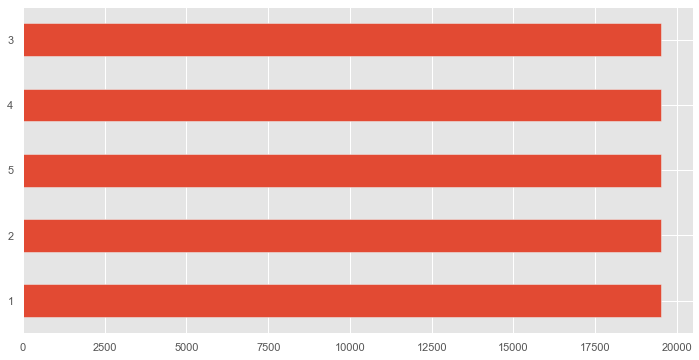

In [168]:
# Amount bins
AMOUNT = True
if AMOUNT:
      final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
      
      final['amount_cat'].value_counts().plot(kind='barh')
      plt.show()
      
      qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
      
      qcut_series.value_counts()

In [169]:
bins = [1,2,3,4,5]
for bin, interval in zip(bins, qcut_intervals):
    print(bin, round(interval,2))

1 0.01
2 21.8
3 84.9
4 215.07
5 549.45


In [170]:
#final[['Amount', 'amount_cat']].head(100)

In [171]:
final['amount_cat'] = final['amount_cat'].astype(str)

In [172]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 4271)
# new variables is  1


In [173]:
# Foreign zipcode
zip_state = pd.read_csv('zip_code_database.csv')[['zip','state']]
zip_state.sample(5)
# Check if the zipcode of merchant is in the US
zip_state = pd.read_csv('zip_code_database.csv')['zip'].astype(float).astype(str).values
zip_state

array(['501.0', '544.0', '601.0', ..., '99928.0', '99929.0', '99950.0'],
      dtype=object)

In [174]:
mapping = list(map(lambda x: x not in zip_state, final['Merch zip']))
final = pd.concat([final, pd.DataFrame({'foreign': mapping})], axis = 1)
final['foreign'] = final['foreign'].astype(int)

In [175]:
final['foreign'].isnull().sum()

0

In [176]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 4272)
# new variables is  1


In [177]:
final.fillna(0,inplace=True)

In [178]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merchnum_zip3_count_0_by_7_sq,merchnum_zip3_count_0_by_14_sq,merchnum_zip3_count_0_by_30_sq,merchnum_zip3_count_0_by_60_sq,merchnum_zip3_count_1_by_7_sq,merchnum_zip3_count_1_by_14_sq,merchnum_zip3_count_1_by_30_sq,merchnum_zip3_count_1_by_60_sq,amount_cat,foreign
0,1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1
1,2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,01803,P,31.42,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2,1
2,3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706,P,178.49,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3,1
3,4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118,P,3.62,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1
4,5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1


In [179]:
final.shape

(97496, 4272)

In [180]:
final.set_index('Recnum', inplace = True)

In [181]:
final.columns.values.tolist()

['Cardnum',
 'Date',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'Amount',
 'Fraud',
 'Dow',
 'Dow_Risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3',
 'Merch state_TE',
 'Merch zip_TE',
 'Dow_TE',
 'Cardnum_day_since',
 'Cardnum_count_0',
 'Cardnum_avg_0',
 'Cardnum_max_0',
 'Cardnum_med_0',
 'Cardnum_total_0',
 'Cardnum_actual/avg_0',
 'Cardnum_actual/max_0',
 'Cardnum_actual/med_0',
 'Cardnum_actual/toal_0',
 'Cardnum_count_1',
 'Cardnum_avg_1',
 'Cardnum_max_1',
 'Cardnum_med_1',
 'Cardnum_total_1',
 'Cardnum_actual/avg_1',
 'Cardnum_actual/max_1',
 'Car

## Find the record number for the out-of-time validation data

These record numbers will be needed later during modeling, since the Date field is removed from the final dataset. They are saved here for reference.

In [182]:
temp = final[final['Date']>='2010-11-01']
ind1 = len(final)-len(temp)
print(final[ind1-3:ind1+3]['Date'])
# final['id1'] = final.index
# id1 = final.loc[indoot]['id1']
temp.reset_index(inplace=True)

Recnum
85261   2010-10-31
85262   2010-10-31
85263   2010-10-31
85264   2010-11-01
85265   2010-11-01
85266   2010-11-01
Name: Date, dtype: datetime64[ns]


In [183]:
temp.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merchnum_zip3_count_0_by_7_sq,merchnum_zip3_count_0_by_14_sq,merchnum_zip3_count_0_by_30_sq,merchnum_zip3_count_0_by_60_sq,merchnum_zip3_count_1_by_7_sq,merchnum_zip3_count_1_by_14_sq,merchnum_zip3_count_1_by_30_sq,merchnum_zip3_count_1_by_60_sq,amount_cat,foreign
0,85264,5142150217,2010-11-01,680699669,GENERALBINDINGCOR,IL,60062,P,182.00,0,...,0.020408,0.005102,0.000556,0.000139,0.020408,0.005102,0.000556,0.000139,3,1
1,85265,5142259911,2010-11-01,615679280335,RICOHCORPORATION,NJ,07006,P,174.61,0,...,0.005102,0.000850,0.000185,0.000028,0.005102,0.000850,0.000185,0.000028,3,1
2,85266,5142224817,2010-11-01,8000326863954,WRIGHTBROTHERSINC.,OH,45237,P,53.00,0,...,0.020408,0.005102,0.001111,0.000013,0.020408,0.005102,0.001111,0.000013,2,1
3,85267,5142250016,2010-11-01,6029900666875,DALLASLAMINATING&FI,TX,75207,P,25.00,0,...,0.020408,0.005102,0.000556,0.000139,0.020408,0.005102,0.000556,0.000139,2,1
4,85268,5142236765,2010-11-01,89200775185,GRTRPHILACABLE,PA,19147,P,97.17,0,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3,1


In [184]:
indoot = temp.loc[0]['Recnum']
print(indoot)

85264


In [185]:
temp = final[final['Date']>='2010-01-15']
ind2 = len(final)-len(temp)
print(final[ind2-3:ind2+3]['Date'])
# final['id1'] = final.index
# id1 = final.loc[indoot]['id1']
temp.reset_index(inplace=True)

Recnum
3463   2010-01-14
3464   2010-01-14
3465   2010-01-14
3466   2010-01-15
3467   2010-01-15
3468   2010-01-15
Name: Date, dtype: datetime64[ns]


In [186]:
temp.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merchnum_zip3_count_0_by_7_sq,merchnum_zip3_count_0_by_14_sq,merchnum_zip3_count_0_by_30_sq,merchnum_zip3_count_0_by_60_sq,merchnum_zip3_count_1_by_7_sq,merchnum_zip3_count_1_by_14_sq,merchnum_zip3_count_1_by_30_sq,merchnum_zip3_count_1_by_60_sq,amount_cat,foreign
0,3466,5142289869,2010-01-15,602608969534,FISHERSCIATL,GA,30091,P,333.47,0,...,0.001361,0.000165,0.000036,8.960573e-06,0.001361,0.000165,0.000036,8.960573e-06,4,1
1,3467,5142148452,2010-01-15,5509006296254,FEDEXSHP01/10/10AB#,TN,38118,P,4.37,0,...,0.000107,0.000017,0.000004,9.048136e-07,0.000107,0.000017,0.000004,9.048136e-07,1,1
2,3468,5142184598,2010-01-15,680655463,MCMASTERCARRSUPP,IL,60126,P,271.93,0,...,0.006803,0.000392,0.000085,2.136752e-05,0.020408,0.001177,0.000256,6.410256e-05,4,1
3,3469,5142148452,2010-01-15,5509006296254,FEDEXSHP01/10/10AB#,TN,38118,P,3.62,0,...,0.000213,0.000033,0.000007,1.803752e-06,0.000213,0.000033,0.000007,1.803752e-06,1,1
4,3470,5142195887,2010-01-15,4503082616100,OFFICEDEPOT#122,NC,27707,P,16.28,0,...,0.006803,0.001020,0.000222,5.555556e-05,0.006803,0.001020,0.000222,5.555556e-05,1,1


In [187]:
ind2w = temp.loc[0]['Recnum']
print(ind2w)

3466


In [188]:
print('Recnum to exclude first 2 weeks:',ind2w)
print('Recnum to exclude oot for feature selection:', indoot)

Recnum to exclude first 2 weeks: 3466
Recnum to exclude oot for feature selection: 85264


In [189]:
final.columns

Index(['Cardnum', 'Date', 'Merchnum', 'Merch description', 'Merch state',
       'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       ...
       'merchnum_zip3_count_0_by_7_sq', 'merchnum_zip3_count_0_by_14_sq',
       'merchnum_zip3_count_0_by_30_sq', 'merchnum_zip3_count_0_by_60_sq',
       'merchnum_zip3_count_1_by_7_sq', 'merchnum_zip3_count_1_by_14_sq',
       'merchnum_zip3_count_1_by_30_sq', 'merchnum_zip3_count_1_by_60_sq',
       'amount_cat', 'foreign'],
      dtype='object', length=4271)

In [190]:
final.head()

,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,...,merchnum_zip3_count_0_by_7_sq,merchnum_zip3_count_0_by_14_sq,merchnum_zip3_count_0_by_30_sq,merchnum_zip3_count_0_by_60_sq,merchnum_zip3_count_1_by_7_sq,merchnum_zip3_count_1_by_14_sq,merchnum_zip3_count_1_by_30_sq,merchnum_zip3_count_1_by_60_sq,amount_cat,foreign
Recnum,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,Friday,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1
2,5142183973,2010-01-01,61003026333,SERVICEMERCHANDISE#81,MA,01803,P,31.42,0,Friday,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2,1
3,5142131721,2010-01-01,4503082993600,OFFICEDEPOT#191,MD,20706,P,178.49,0,Friday,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3,1
4,5142148452,2010-01-01,5509006296254,FEDEXSHP12/28/09AB#,TN,38118,P,3.62,0,Friday,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1
5,5142190439,2010-01-01,5509006296254,FEDEXSHP12/23/09AB#,TN,38118,P,3.62,0,Friday,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1


In [191]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'zip3',
 'card_zip3',
 'state_zip',
 'merchnum_zip3']

In [192]:
drop_columns = ['Date','Merch description','Merch state','Merch zip','Transtype','Dow']
final.drop(columns=entities,inplace=True)
final.drop(columns=drop_columns,inplace=True)
final.columns

Index(['Amount', 'Fraud', 'Dow_Risk', 'Merch state_TE', 'Merch zip_TE',
       'Dow_TE', 'Cardnum_day_since', 'Cardnum_count_0', 'Cardnum_avg_0',
       'Cardnum_max_0',
       ...
       'merchnum_zip3_count_0_by_7_sq', 'merchnum_zip3_count_0_by_14_sq',
       'merchnum_zip3_count_0_by_30_sq', 'merchnum_zip3_count_0_by_60_sq',
       'merchnum_zip3_count_1_by_7_sq', 'merchnum_zip3_count_1_by_14_sq',
       'merchnum_zip3_count_1_by_30_sq', 'merchnum_zip3_count_1_by_60_sq',
       'amount_cat', 'foreign'],
      dtype='object', length=4238)

In [193]:
final.head()

,Amount,Fraud,Dow_Risk,Merch state_TE,Merch zip_TE,Dow_TE,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,...,merchnum_zip3_count_0_by_7_sq,merchnum_zip3_count_0_by_14_sq,merchnum_zip3_count_0_by_30_sq,merchnum_zip3_count_0_by_60_sq,merchnum_zip3_count_1_by_7_sq,merchnum_zip3_count_1_by_14_sq,merchnum_zip3_count_1_by_30_sq,merchnum_zip3_count_1_by_60_sq,amount_cat,foreign
Recnum,,,,,,,,,,,,,,,,,,,,,
1,3.62,0,0.031756,0.017176,0.020604,0.031756,1461.0,1,3.62,3.62,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1
2,31.42,0,0.031756,0.015752,0.020604,0.031756,1461.0,1,31.42,31.42,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,2,1
3,178.49,0,0.031756,0.028553,0.020604,0.031756,1461.0,1,178.49,178.49,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,3,1
4,3.62,0,0.031756,0.017176,0.020604,0.031756,1461.0,1,3.62,3.62,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1
5,3.62,0,0.031756,0.017176,0.020604,0.031756,0.0,2,3.62,3.62,...,0.020408,0.005102,0.001111,0.000278,0.020408,0.005102,0.001111,0.000278,1,1


In [194]:
%%time
# Remove any redundant columns.

print('before removing redundant columns:',final.shape)
final = final.T.drop_duplicates().T
print('after removing redundant columns:',final.shape)

before removing redundant columns: (97496, 4238)
after removing redundant columns: (97496, 3334)
CPU times: user 55.1 s, sys: 19.7 s, total: 1min 14s
Wall time: 1min 26s


In [195]:
# check to see if all the entries are numeric rather than categorical. 
# If False, then some are not numeric. We want True.
final_numeric = final.apply(pd.to_numeric, errors='coerce')
is_all_numeric = not final_numeric.isnull().values.any()
print(is_all_numeric)

True


In [209]:
final['amount_cat']

Recnum
1        1
2        2
3        3
4        1
5        1
        ..
97848    2
97849    3
97850    4
97851    5
97852    5
Name: amount_cat, Length: 97496, dtype: object

In [202]:
for col in final.columns:
    
    print(col)

Amount
Fraud
Dow_Risk
Merch state_TE
Merch zip_TE
Cardnum_day_since
Cardnum_count_0
Cardnum_avg_0
Cardnum_max_0
Cardnum_med_0
Cardnum_total_0
Cardnum_actual/avg_0
Cardnum_actual/max_0
Cardnum_actual/med_0
Cardnum_actual/toal_0
Cardnum_count_1
Cardnum_avg_1
Cardnum_max_1
Cardnum_med_1
Cardnum_total_1
Cardnum_actual/avg_1
Cardnum_actual/max_1
Cardnum_actual/med_1
Cardnum_actual/toal_1
Cardnum_count_3
Cardnum_avg_3
Cardnum_max_3
Cardnum_med_3
Cardnum_total_3
Cardnum_actual/avg_3
Cardnum_actual/max_3
Cardnum_actual/med_3
Cardnum_actual/toal_3
Cardnum_count_7
Cardnum_avg_7
Cardnum_max_7
Cardnum_med_7
Cardnum_total_7
Cardnum_actual/avg_7
Cardnum_actual/max_7
Cardnum_actual/med_7
Cardnum_actual/toal_7
Cardnum_count_14
Cardnum_avg_14
Cardnum_max_14
Cardnum_med_14
Cardnum_total_14
Cardnum_actual/avg_14
Cardnum_actual/max_14
Cardnum_actual/med_14
Cardnum_actual/toal_14
Cardnum_count_30
Cardnum_avg_30
Cardnum_max_30
Cardnum_med_30
Cardnum_total_30
Cardnum_actual/avg_30
Cardnum_actual/max_30
Cardn

Card_Merchnum_Zip_unique_count_for_Merchnum_dow_60
Card_Merchnum_Zip_unique_count_for_Merchdesc_dow_1
Card_Merchnum_Zip_unique_count_for_Merchdesc_dow_3
Card_Merchnum_Zip_unique_count_for_Merchdesc_dow_7
Card_Merchnum_Zip_unique_count_for_Merchdesc_dow_14
Card_Merchnum_Zip_unique_count_for_Merchdesc_dow_30
Card_Merchnum_Zip_unique_count_for_Merchdesc_dow_60
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_State_1
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_State_3
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_State_7
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_State_14
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_State_30
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_State_60
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_Zip_7
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_Zip_14
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_Zip_30
Card_Merchdesc_Zip_unique_count_for_Merchnum_desc_Zip_60
Card_Merchdesc_Zip_unique_count_for_Merchdesc_State_60
Merchnu

In [205]:
len(final.columns)

3334

## New feature enriched dataset

In [196]:
final.to_csv('candidate_variables.csv')

In [207]:
from collections import defaultdict
import itertools

columns = final.columns

# This function will determine if two column names are similar based on a simple criterion:
# if one name contains the other.
def are_columns_similar(col1, col2):
    return col1 in col2 or col2 in col1

# Group similar columns together
groups = defaultdict(list)
for col1, col2 in itertools.combinations(columns, 2):
    if are_columns_similar(col1, col2):
        groups[col1].append(col2)
        groups[col2].append(col1)

# Remove duplicates and self-references in groups
for col in columns:
    groups[col] = list(set(groups[col]) - {col})

# Create a dictionary with counts of similar variables
similar_columns_count = {col: len(similar_cols) for col, similar_cols in groups.items() if similar_cols}

# Print out groups and counts
for col, group in groups.items():
    print(f"{col} has {len(group)} similar columns: {group}")

print("\nCounts of similar columns:", similar_columns_count)

Cardnum_count_0 has 8 similar columns: ['Cardnum_count_0_by_30', 'Cardnum_count_0_by_14_sq', 'Cardnum_count_0_by_60', 'Cardnum_count_0_by_14', 'Cardnum_count_0_by_7_sq', 'Cardnum_count_0_by_30_sq', 'Cardnum_count_0_by_60_sq', 'Cardnum_count_0_by_7']
Cardnum_count_0_by_7 has 2 similar columns: ['Cardnum_count_0_by_7_sq', 'Cardnum_count_0']
Cardnum_count_0_by_14 has 2 similar columns: ['Cardnum_count_0_by_14_sq', 'Cardnum_count_0']
Cardnum_count_0_by_30 has 2 similar columns: ['Cardnum_count_0_by_30_sq', 'Cardnum_count_0']
Cardnum_count_0_by_60 has 2 similar columns: ['Cardnum_count_0_by_60_sq', 'Cardnum_count_0']
Cardnum_count_0_by_7_sq has 2 similar columns: ['Cardnum_count_0_by_7', 'Cardnum_count_0']
Cardnum_count_0_by_14_sq has 2 similar columns: ['Cardnum_count_0_by_14', 'Cardnum_count_0']
Cardnum_count_0_by_30_sq has 2 similar columns: ['Cardnum_count_0', 'Cardnum_count_0_by_30']
Cardnum_count_0_by_60_sq has 2 similar columns: ['Cardnum_count_0_by_60', 'Cardnum_count_0']
Cardnum_co

Card_Merchnum_State_total_amount_0_by_14 has 0 similar columns: []
Card_Merchnum_State_total_amount_0_by_30 has 0 similar columns: []
Card_Merchnum_State_total_amount_0_by_60 has 0 similar columns: []
Card_Merchnum_State_total_amount_1_by_7 has 0 similar columns: []
Card_Merchnum_State_total_amount_1_by_14 has 0 similar columns: []
Card_Merchnum_State_total_amount_1_by_30 has 0 similar columns: []
Card_Merchnum_State_total_amount_1_by_60 has 0 similar columns: []
Card_Merchdesc_State_total_amount_0_by_7 has 0 similar columns: []
Card_Merchdesc_State_total_amount_0_by_14 has 0 similar columns: []
Card_Merchdesc_State_total_amount_0_by_30 has 0 similar columns: []
Card_Merchdesc_State_total_amount_0_by_60 has 0 similar columns: []
Card_Merchdesc_State_total_amount_1_by_7 has 0 similar columns: []
Card_Merchdesc_State_total_amount_1_by_14 has 0 similar columns: []
Card_Merchdesc_State_total_amount_1_by_30 has 0 similar columns: []
Card_Merchdesc_State_total_amount_1_by_60 has 0 similar co